In [2]:
import numpy as np
import pygimli as pg
#import pybert as pb
from pygimli.physics import ert
#from pybert.importer.exportData import exportRes2dInv
from pygimli.physics.ert.importData import importRes2dInv
import matplotlib.pyplot as plt
import pygimli.meshtools as mt
from pygimli.frameworks import PriorModelling, JointModelling
from scipy.interpolate import interp1d
import pandas as pd
import pickle
from pygimli.viewer.mpl import draw1DColumn, drawSensors
import statsmodels.api as sm
from matplotlib.ticker import LogLocator, LogFormatter
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import matplotlib.image as mpimg
import matplotlib.cm as cm


In [3]:
dir='//smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/'

In [4]:
mesh_eastern = pg.load(dir+'pygimli/all_inversions/INV_Eastern_and_south/ERTManager/resistivity-pd.bms')
res_eastern = pg.load(dir+'pygimli/all_inversions/INV_Eastern_and_south/ERTManager/resistivity.vector')
cov_eastern = pg.load(dir+'pygimli/all_inversions/INV_Eastern_and_south/ERTManager/resistivity-cov.vector')

mesh_eastern_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_eastern_perpendicular/resistivity-pd.bms')
res_eastern_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_eastern_perpendicular/resistivity.vector')
cov_eastern_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_eastern_perpendicular/resistivity-cov.vector')

mesh_western = pg.load(dir+'pygimli/all_inversions/ERTManager_western/resistivity-pd.bms')
res_western = pg.load(dir+'pygimli/all_inversions/ERTManager_western/resistivity.vector')
cov_western = pg.load(dir+'pygimli/all_inversions/ERTManager_western/resistivity-cov.vector')

mesh_western_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_western_perpendicular/resistivity-pd.bms')
res_western_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_western_perpendicular/resistivity.vector')
cov_western_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_western_perpendicular/resistivity-cov.vector')

mesh_southeast = pg.load(dir+'pygimli/all_inversions/ERTManager_southeast/resistivity-pd.bms')
res_southeast = pg.load(dir+'pygimli/all_inversions/ERTManager_southeast/resistivity.vector')
cov_southeast = pg.load(dir+'pygimli/all_inversions/ERTManager_southeast/resistivity-cov.vector')

mesh_arenson = pg.load(dir+'pygimli/all_inversions/arenson_updated/ERTManager/resistivity-pd.bms')
res_arenson = pg.load(dir+'pygimli/all_inversions/arenson_updated/ERTManager/resistivity.vector')
cov_arenson = pg.load(dir+'pygimli/all_inversions/arenson_updated/ERTManager/resistivity-cov.vector')

mesh_eastern_center = pg.load(dir+'pygimli/all_inversions/INV_Eastern_centern/ERTManager/resistivity-pd.bms')
res_eastern_center = pg.load(dir+'pygimli/all_inversions/INV_Eastern_centern/ERTManager/resistivity.vector')
cov_eastern_center = pg.load(dir+'pygimli/all_inversions/INV_Eastern_centern/ERTManager/resistivity-cov.vector')

Eastern - permafrost table

In [5]:
topography_coords = np.loadtxt(dir + "res2dinv_inputs/eastern_newtopo.txt")
xmin = -130
xmax = 385
ymin = -40
resolution_x = 0.1
resolution_y = 0.1
shave_off_top = 0.5 


interpolated_topography = interp1d(topography_coords[:, 0], topography_coords[:, 1], kind='linear', fill_value='extrapolate')


x = np.arange(xmin, xmax + resolution_x, resolution_x)


adjusted_topography = []


for x_val in x:
    y_val = interpolated_topography(x_val)
    adjusted_y_val = max(y_val - shave_off_top, ymin)  
    adjusted_topography.append(adjusted_y_val)


adjusted_topography = np.array(adjusted_topography)


grid_points = []

for x_val, y_val in zip(x, adjusted_topography):
    y_range = np.arange(y_val, ymin - resolution_y, -resolution_y)
    grid_points.extend([(x_val, y) for y in y_range])

grid_points = np.array(grid_points)

posVec = [pg.Pos(pos) for pos in zip(grid_points[:, 0], grid_points[:, 1])]


mesh_eastern.setCellMarkers(pg.IVector(mesh_eastern.cellCount()))

fopDP = PriorModelling(mesh_eastern, posVec)


resMesh = fopDP(res_eastern)

out = np.column_stack((grid_points[:, 0], grid_points[:, 1], resMesh))

x_values = out[:, 0]
y_values = out[:, 1]
resistivity_values = out[:, 2]

04/08/24 - 19:13:54 - pyGIMLi - INFO - Found 1 regions.


In [6]:
top_permafrost_depths = []
permafrost_data = []
# Iterate over each unique x value
for x_value in np.unique(out[:, 0]):
    # Filter data for the current x value
    data_x = out[out[:, 0] == x_value]

    # Calculate resistivity gradient in logarithmic space
    #resistivity_gradient_log = (data_x[:, 2])/data_x[:, 1]
    resistivity_gradient_log = np.diff(np.log10(data_x[:, 2])) / np.diff(data_x[:, 1])
    #grad = pd.DataFrame(rho.diff(axis=1).values / depth.diff(axis=1).values)
    #grad_log = pd.DataFrame(np.log10(rho).diff(axis=1).values / depth.diff(axis=1).values)
    # Filter gradients based on criteria

    
    if x_value < 110:
        # Calculate the gradient up to the maximum depth
        valid_gradients_mask = (data_x[:-1, 2] > 10) & (resistivity_gradient_log < 0) & (np.abs(resistivity_gradient_log) > 0.1) 
        valid_gradients = resistivity_gradient_log[valid_gradients_mask]
        valid_depths = data_x[:-1, 1][valid_gradients_mask]
        
    elif x_value > 240:
        # Calculate the gradient only up to depth 10
        valid_gradients_mask = (data_x[:-1, 2] > 10) & (resistivity_gradient_log < 0) & (np.abs(resistivity_gradient_log) > 0.1) 
        valid_gradients = resistivity_gradient_log[valid_gradients_mask]
        valid_depths = data_x[:-1, 1][valid_gradients_mask]

    # Find depth of the top of permafrost table with the maximum negative gradient
    #if len(valid_depths) > 0:
    #    max_gradient_index = np.argmax(valid_gradients)
    #    top_permafrost_depth = valid_depths[max_gradient_index]
    #    max_gradient_value = valid_gradients[max_gradient_index]
    #    top_permafrost_depths.append((x_value, top_permafrost_depth, max_gradient_value))

    if len(valid_depths) > 0:
        top_permafrost_depth = valid_depths[0]
        gradient = valid_gradients[0]
        permafrost_data.append((x_value, top_permafrost_depth, gradient))
# Convert top_permafrost_depths to numpy array
#top_permafrost_depths = np.array(top_permafrost_depths)
top_permafrost_depths = np.array(permafrost_data)

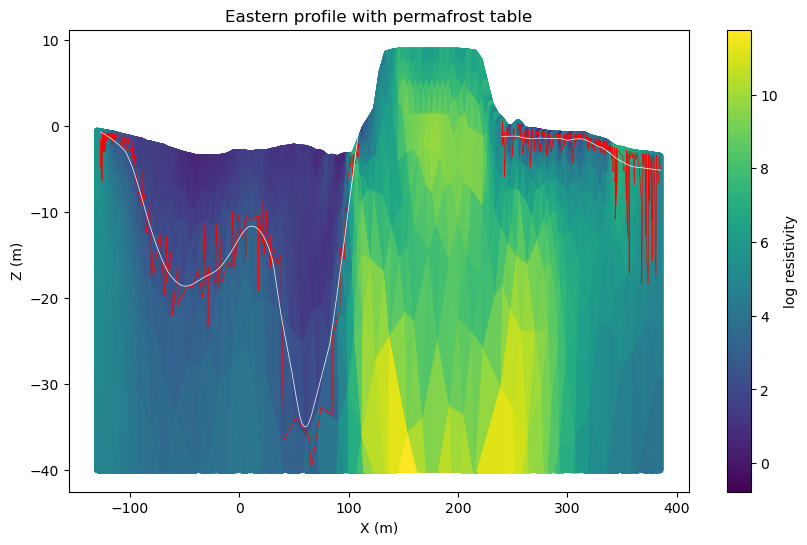

In [7]:
x_values = out[:, 0]
y_values = out[:, 1]
resistivity_values = out[:, 2]
ibpt_depth = top_permafrost_depths[:, 1]
ibpt_x = top_permafrost_depths[:, 0] 
section1_ibpt_depths = top_permafrost_depths[(top_permafrost_depths[:, 0] < 110)]
section2_ibpt_depths = top_permafrost_depths[(top_permafrost_depths[:, 0] > 240)]


lowess = sm.nonparametric.lowess
frac = 0.2  
ibpt_depth_smoothed1 = lowess(section1_ibpt_depths[:, 1], section1_ibpt_depths[:, 0], frac=frac)[:, 1]
ibpt_depth_smoothed2 = lowess(section2_ibpt_depths[:, 1], section2_ibpt_depths[:, 0], frac=frac)[:, 1]


plt.figure(figsize=(10, 6))

plt.scatter(x_values, y_values, c=np.log(resistivity_values), cmap='viridis', s=10)  
plt.colorbar(label='log resistivity')
plt.xlabel('X (m)')
plt.ylabel('Z (m)')
plt.title('Eastern profile with permafrost table')


# Plot unsmoothed data
plt.plot(section1_ibpt_depths[:, 0], section1_ibpt_depths[:, 1], color='r', linewidth=0.5)
plt.plot(section2_ibpt_depths[:, 0], section2_ibpt_depths[:, 1], color='r', linewidth=0.5)

# Plot smoothed data (commented out)
plt.plot(section1_ibpt_depths[:, 0], ibpt_depth_smoothed1, color='w', linewidth=0.5)
plt.plot(section2_ibpt_depths[:, 0], ibpt_depth_smoothed2, color='w', linewidth=0.5)

np.save(dir+ 'pygimli/eastern_perm_table_smooth1.npy', ibpt_depth_smoothed1)
np.save(dir+ 'pygimli/eastern_perm_table_smooth2.npy', ibpt_depth_smoothed2)
np.save(dir+ 'pygimli/eastern_perm_table1.npy', section1_ibpt_depths[:, 1])
np.save(dir+ 'pygimli/eastern_perm_table2.npy', section2_ibpt_depths[:, 1])
np.save(dir+ 'pygimli/eastern_perm_table_x1.npy', section1_ibpt_depths[:, 0])
np.save(dir+ 'pygimli/eastern_perm_table_x2.npy', section2_ibpt_depths[:, 0])


Western - permafrost table

In [8]:
topography_coords = np.loadtxt(dir + "res2dinv_inputs/western_topo.txt")
xmin = -10
xmax = 310
ymin = -40
resolution_x = 0.1
resolution_y = 0.1
shave_off_top = 0.5  # Amount to shave off from the top

interpolated_topography = interp1d(topography_coords[:, 0], topography_coords[:, 1], kind='linear', fill_value='extrapolate')


x = np.arange(xmin, xmax + resolution_x, resolution_x)


adjusted_topography = []


for x_val in x:
    y_val = interpolated_topography(x_val)
    adjusted_y_val = max(y_val - shave_off_top, ymin)  
    adjusted_topography.append(adjusted_y_val)


adjusted_topography = np.array(adjusted_topography)


grid_points = []

for x_val, y_val in zip(x, adjusted_topography):
    y_range = np.arange(y_val, ymin - resolution_y, -resolution_y)
    grid_points.extend([(x_val, y) for y in y_range])

grid_points = np.array(grid_points)

posVec = [pg.Pos(pos) for pos in zip(grid_points[:, 0], grid_points[:, 1])]


mesh_western.setCellMarkers(pg.IVector(mesh_western.cellCount()))

fopDP = PriorModelling(mesh_western, posVec)


resMesh = fopDP(res_western)

out = np.column_stack((grid_points[:, 0], grid_points[:, 1], resMesh))

x_values = out[:, 0]
y_values = out[:, 1]
resistivity_values = out[:, 2]

04/08/24 - 19:22:27 - pyGIMLi - INFO - Found 1 regions.


In [9]:
top_permafrost_depths = []
permafrost_data = []
# Iterate over each unique x value
for x_value in np.unique(out[:, 0]):
    # Filter data for the current x value
    data_x = out[out[:, 0] == x_value]

    # Calculate resistivity gradient in logarithmic space
    resistivity_gradient_log = np.diff(np.log10(data_x[:, 2])) / np.diff(data_x[:, 1])
    #grad = pd.DataFrame(rho.diff(axis=1).values / depth.diff(axis=1).values)
    #grad_log = pd.DataFrame(np.log10(rho).diff(axis=1).values / depth.diff(axis=1).values)
    if x_value < 110:
        # Calculate the gradient up to the maximum depth
        valid_gradients_mask = (data_x[:-1, 2] > 10) & (resistivity_gradient_log < 0) & (np.abs(resistivity_gradient_log) > 0.1) 
        valid_gradients = resistivity_gradient_log[valid_gradients_mask]
        valid_depths = data_x[:-1, 1][valid_gradients_mask]
        
    elif x_value > 180:
        # Calculate the gradient only up to depth 10
        valid_gradients_mask = (data_x[:-1, 2] > 10) & (resistivity_gradient_log < 0) & (np.abs(resistivity_gradient_log) > 0.1) 
        valid_gradients = resistivity_gradient_log[valid_gradients_mask]
        valid_depths = data_x[:-1, 1][valid_gradients_mask]

    # Find depth of the top of permafrost table with the maximum negative gradient
    #if len(valid_depths) > 0:
    #    max_gradient_index = np.argmax(valid_gradients)
    #    top_permafrost_depth = valid_depths[max_gradient_index]
    #    max_gradient_value = valid_gradients[max_gradient_index]
    #    top_permafrost_depths.append((x_value, top_permafrost_depth, max_gradient_value))

    if len(valid_depths) > 0:
        top_permafrost_depth = valid_depths[0]
        gradient = valid_gradients[0]
        permafrost_data.append((x_value, top_permafrost_depth, gradient))
        
# Convert top_permafrost_depths to numpy array
#top_permafrost_depths = np.array(top_permafrost_depths)
top_permafrost_depths = np.array(permafrost_data)

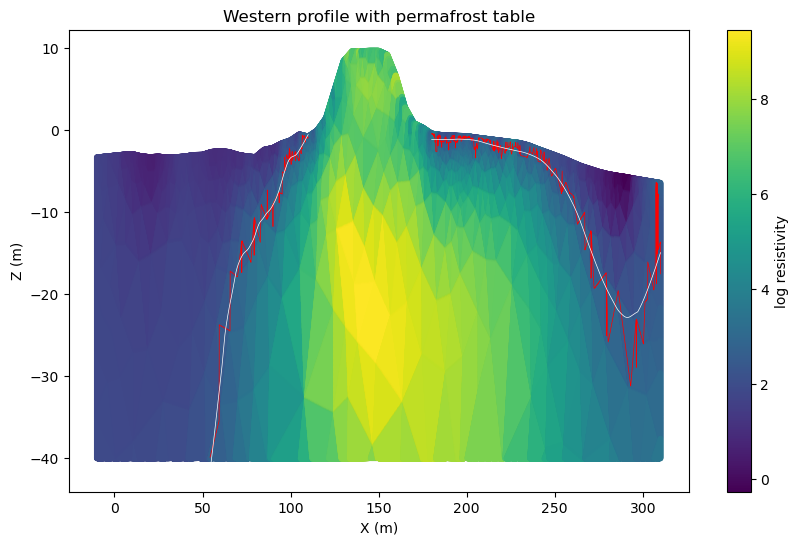

In [10]:
x_values = out[:, 0]
y_values = out[:, 1]
resistivity_values = out[:, 2]
ibpt_depth = top_permafrost_depths[:, 1]
ibpt_x = top_permafrost_depths[:, 0] 
section1_ibpt_depths = top_permafrost_depths[(top_permafrost_depths[:, 0] < 110)]
section2_ibpt_depths = top_permafrost_depths[(top_permafrost_depths[:, 0] > 180)]


lowess = sm.nonparametric.lowess
frac = 0.2  
ibpt_depth_smoothed1 = lowess(section1_ibpt_depths[:, 1], section1_ibpt_depths[:, 0], frac=frac)[:, 1]
ibpt_depth_smoothed2 = lowess(section2_ibpt_depths[:, 1], section2_ibpt_depths[:, 0], frac=frac)[:, 1]


plt.figure(figsize=(10, 6))

plt.scatter(x_values, y_values, c=np.log(resistivity_values), cmap='viridis', s=10)  
plt.colorbar(label='log resistivity')
plt.xlabel('X (m)')
plt.ylabel('Z (m)')
plt.title('Western profile with permafrost table')


# Plot unsmoothed data
plt.plot(section1_ibpt_depths[:, 0], section1_ibpt_depths[:, 1], color='r', linewidth=0.5)
plt.plot(section2_ibpt_depths[:, 0], section2_ibpt_depths[:, 1], color='r', linewidth=0.5)

# Plot smoothed data (commented out)
plt.plot(section1_ibpt_depths[:, 0], ibpt_depth_smoothed1, color='w', linewidth=0.5)
plt.plot(section2_ibpt_depths[:, 0], ibpt_depth_smoothed2, color='w', linewidth=0.5)

np.save(dir+ 'pygimli/western_perm_table_smooth1.npy', ibpt_depth_smoothed1)
np.save(dir+ 'pygimli/western_perm_table_smooth2.npy', ibpt_depth_smoothed2)
np.save(dir+ 'pygimli/western_perm_table1.npy', section1_ibpt_depths[:, 1])
np.save(dir+ 'pygimli/western_perm_table2.npy', section2_ibpt_depths[:, 1])
np.save(dir+ 'pygimli/western_perm_table_x1.npy', section1_ibpt_depths[:, 0])
np.save(dir+ 'pygimli/western_perm_table_x2.npy', section2_ibpt_depths[:, 0])

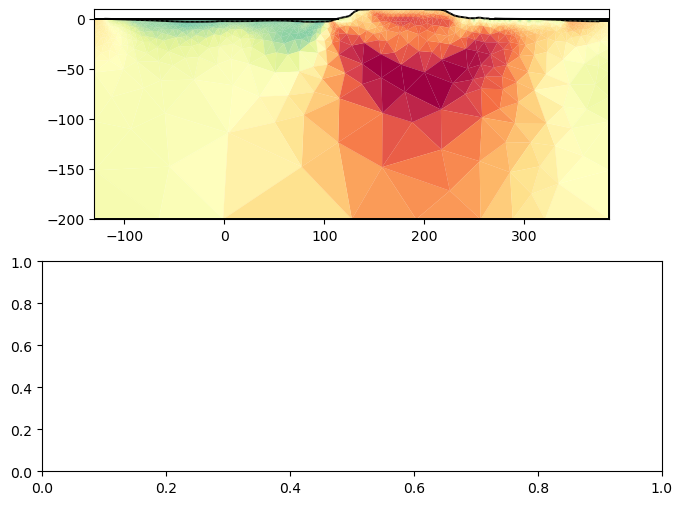

Text(0.5, 26.12222222222222, 'Logarithmic Scale of Resistivity (ohm-m)')

<Figure size 640x480 with 0 Axes>

In [11]:
from matplotlib.ticker import LogLocator, LogFormatter
fig, ax = plt.subplots(2, 1, figsize=(8, 6))


# Plot on the subplots
pg.show(mesh_eastern, res_eastern, logScale=True, cMap="Spectral_r", ax=ax[0], cMin=0.1, cMax=100000,colorBar=False)
pg.show(mesh_western, res_western, logScale=True, cMap="Spectral_r", ax=ax[1], cMin=0.1, cMax=100000,colorBar=False)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.2) 

# Add titles, labels, etc.
ax[0].set_title('Eastern')
ax[1].set_title('Western')
ax[0].set_ylim(-50, 15)
ax[1].set_ylim(-50, 15)
#ax.set_xlim(-11,381)


cax = fig.add_axes([0.1, 0.1, 0.8, 0.04])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, cMin=0.1, cMax=100000, logScale=True, cMap="Spectral_r")

# Set aspect ratio to equal for both subplots
#ax[0].set_aspect(2)
#ax[1].set_aspect(1.1)


cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Logarithmic Scale of Resistivity (ohm-m)', fontsize=10)

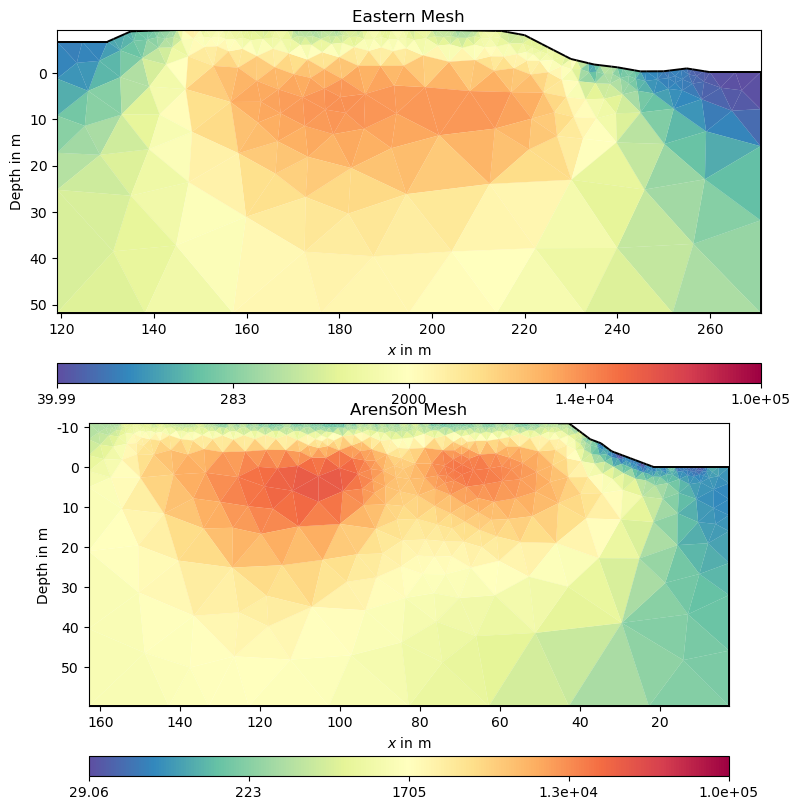

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))


# Plot on the subplots
pg.show(mesh_eastern_center, res_eastern_center, logScale=True, cMap="Spectral_r", ax=ax[0], cMin=0, cMax=100000)
pg.show(mesh_arenson, res_arenson, logScale=True, cMap="Spectral_r", ax=ax[1], cMin=0, cMax=100000)

# Add titles, labels, etc.
ax[0].set_title('Eastern Mesh')
ax[1].set_title('Arenson Mesh')
#ax[0].set_ylim(-50, 15)
#ax[1].set_ylim(-50, 15)
#ax[0].set_xlim(120, 275)
#ax[1].set_xlim(0, 155)
ax[1].invert_xaxis()

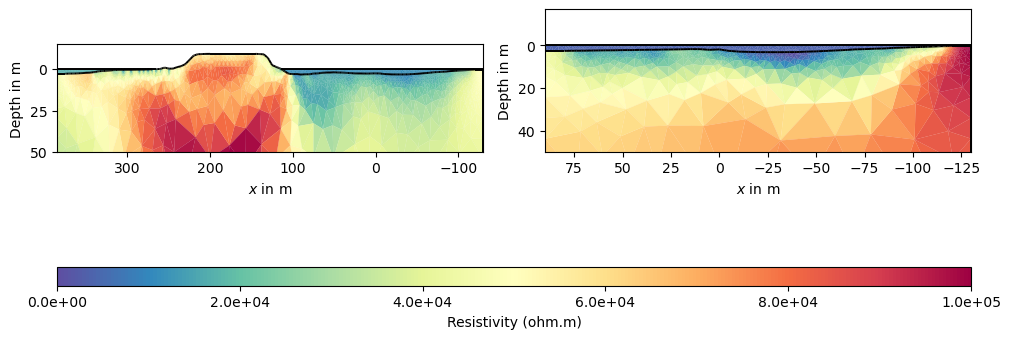

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pygimli as pg  # assuming pg is an alias for PyGIMLi

# Define common normalization and colormap for linear scale
cmin = 0
cmax = 100000
norm = mcolors.Normalize(vmin=cmin, vmax=cmax)
cmap = "Spectral_r"

# Create a 1x2 grid of subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

# Plot on the subplots with the common normalization and colormap
_, img1 = pg.show(mesh_southeast, res_southeast, norm=norm, cMap=cmap, ax=ax[1], colorBar=False, logScale=True)
_, img0 = pg.show(mesh_eastern, res_eastern, norm=norm, cMap=cmap, ax=ax[0], colorBar=False, logScale=True)

# Add titles, labels, etc.
# ax[1].set_title('Eastern Mesh')
# ax[0].set_title('Southeast Mesh')
ax[1].set_ylim(-50, 17)
ax[0].set_ylim(-50, 15)
ax[0].invert_xaxis()
ax[1].invert_xaxis()

# Set aspect ratio to equal for both subplots
ax[0].set_aspect(2)
ax[1].set_aspect(1.1)

# Create a shared colorbar using the normalization
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable

cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', format='%.1e', aspect=50)
cbar.set_label('Resistivity (ohm.m)')  # Customize the label as needed

#plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the colorbar
plt.show()



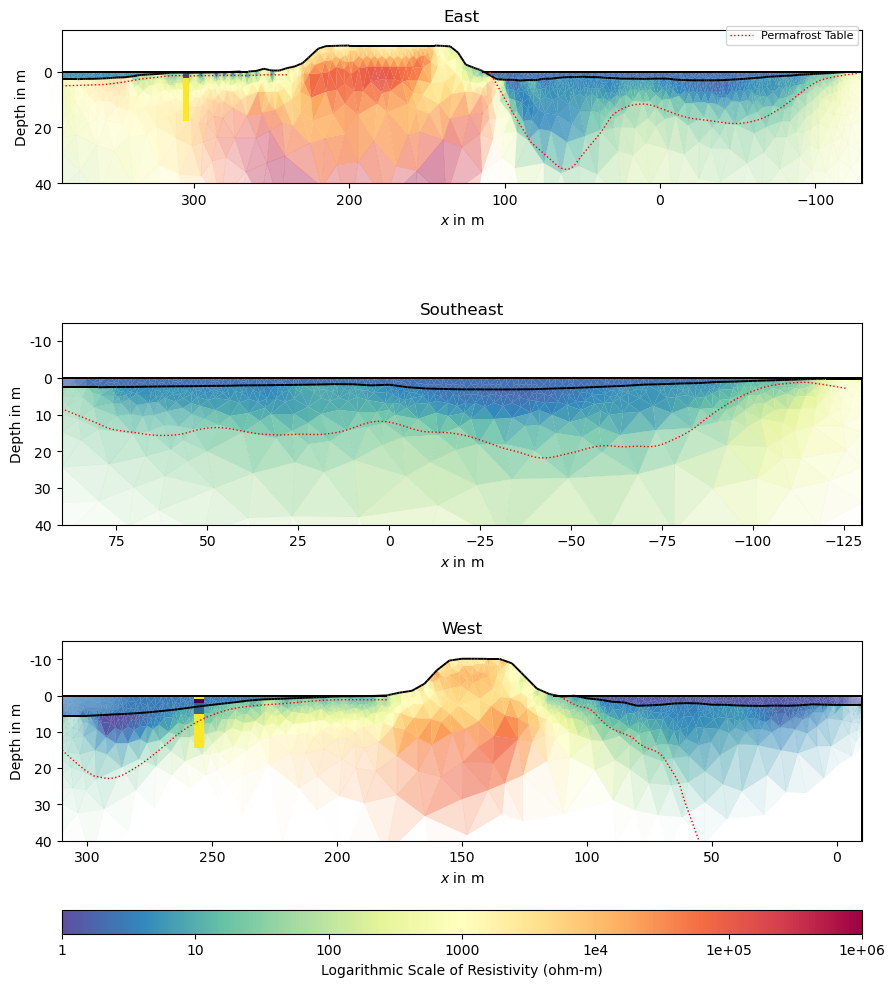

In [14]:
from matplotlib.ticker import LogLocator, LogFormatter

borehole4 = pd.read_csv(dir + "pygimli/borehole4.csv")
borehole2 = pd.read_csv(dir + "pygimli/borehole2.csv")

AL = np.loadtxt(dir + "pygimli/AL_eastern.txt")

e_permafrost_table1 = np.load(dir+ 'pygimli/eastern_perm_table1.npy')
e_permafrost_table_smooth1 = np.load(dir+ 'pygimli/eastern_perm_table_smooth1.npy')
e_permafrost_table_x1 = np.load(dir+ 'pygimli/eastern_perm_table_x1.npy')

e_permafrost_table2 = np.load(dir+ 'pygimli/eastern_perm_table2.npy')
e_permafrost_table_smooth2 = np.load(dir+ 'pygimli/eastern_perm_table_smooth2.npy')
e_permafrost_table_x2 = np.load(dir+ 'pygimli/eastern_perm_table_x2.npy')

s_permafrost_table = np.load(dir+ 'pygimli/southeast_perm_table.npy')
s_permafrost_table_smooth = np.load(dir+ 'pygimli/southeast_perm_table_smooth.npy')
s_permafrost_table_x = np.load(dir+ 'pygimli/southeast_perm_table_x.npy')

w_permafrost_table1 = np.load(dir+ 'pygimli/western_perm_table1.npy')
w_permafrost_table_smooth1 = np.load(dir+ 'pygimli/western_perm_table_smooth1.npy')
w_permafrost_table_x1 = np.load(dir+ 'pygimli/western_perm_table_x1.npy')

w_permafrost_table2 = np.load(dir+ 'pygimli/western_perm_table2.npy')
w_permafrost_table_smooth2 = np.load(dir+ 'pygimli/western_perm_table_smooth2.npy')
w_permafrost_table_x2 = np.load(dir+ 'pygimli/western_perm_table_x2.npy')

x_e = borehole4['x']
z_e = borehole4['z']
r_e = borehole4['r']

x_w = borehole2['x']
z_w = borehole2['z']
r_w = borehole2['r']

x_AL = AL[0]
z_AL = AL[1]


fig, ax = plt.subplots(3, 1, figsize=(10, 12))  
#fig, ax = plt.subplots(1, 2, figsize=(10, 10))

pg.show(mesh_eastern, res_eastern, logScale=True, cMap="Spectral_r", ax=ax[0], colorBar=False, cMin=1, cMax=100000, coverage=cov_eastern)
pg.show(mesh_southeast, res_southeast, logScale=True, cMap="Spectral_r", ax=ax[1], colorBar=False, cMin=1, cMax=100000, coverage=cov_southeast)
pg.show(mesh_western, res_western, logScale=True, cMap="Spectral_r", ax=ax[2], colorBar=False, cMin=1, cMax=100000, coverage=cov_western)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.2) 


cax = fig.add_axes([0.1, 0.1, 0.8, 0.02])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, cMin=1, cMax=1000000, logScale=True, cMap="Spectral_r")

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Logarithmic Scale of Resistivity (ohm-m)', fontsize=10)

ax[1].set_title('Southeast')
ax[0].set_title('East')
ax[2].set_title('West')

ax[1].set_ylim(-40, 15)
ax[0].set_ylim(-40, 15)
ax[2].set_ylim(-40, 15)

ax[0].invert_xaxis()
ax[1].invert_xaxis()
ax[2].invert_xaxis()

ax[0].set_aspect(1.8)
ax[1].set_aspect(1.01)
ax[2].set_aspect(1.45)

zz_e = np.abs(z_e)
iz_e = np.argsort(z_e)
dz_e = np.diff(zz_e[iz_e])
thk_e = np.hstack([dz_e, dz_e[-1]])
ztop_e = -zz_e[iz_e[0]]-dz_e[0]/2
colkw_e = dict(x=x_e[0], val=r_e[iz_e], thk=thk_e, width=4, ztopo=ztop_e)
draw1DColumn(ax[0], **colkw_e)

zz_w = np.abs(z_w)
iz_w = np.argsort(z_w)
dz_w = np.diff(zz_w[iz_w])
thk_w = np.hstack([dz_w, dz_w[-1]])
ztop_w = -zz_w[iz_w[0]]-dz_w[0]/2
colkw_w = dict(x=x_w[0], val=r_w[iz_w], thk=thk_w, width=4, ztopo=ztop_w)
draw1DColumn(ax[2], **colkw_w)

line1, = ax[0].plot(e_permafrost_table_x1, e_permafrost_table_smooth1, ":", linewidth=1, color='red', label='Permafrost Table')
line2, = ax[0].plot(e_permafrost_table_x2, e_permafrost_table_smooth2, ":", linewidth=1, color='red')
line3, = ax[1].plot(s_permafrost_table_x, s_permafrost_table_smooth, ":", linewidth=1, color='red')
line4, = ax[2].plot(w_permafrost_table_x1, w_permafrost_table_smooth1, ":", linewidth=1, color='red')
line5, = ax[2].plot(w_permafrost_table_x2, w_permafrost_table_smooth2, ":", linewidth=1, color='red')

#line1, = ax[0].plot(e_permafrost_table_x, e_permafrost_table, ":", linewidth=1, color='red', label='Permafrost Table')
#line2, = ax[1].plot(s_permafrost_table_x, s_permafrost_table, ":", linewidth=1, color='red')
#line2, = ax[2].plot(w_permafrost_table_x, w_permafrost_table, ":", linewidth=1, color='red')
#ax[0].plot(x_AL, z_AL, 'g_', linewidth=0.1)

ax[0].legend(loc=(0.83, 0.9), fontsize=8)

plt.show()



04/08/24 - 19:29:22 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv
04/08/24 - 19:29:23 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv
04/08/24 - 19:29:23 - pyGIMLi - INFO - Cache C:\Users\mealiy001\Projects\tuk_island\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.4s x 67): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\4653169337310691530
04/08/24 - 19:29:23 - pyGIMLi - INFO - Cache C:\Users\mealiy001\Projects\tuk_island\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 67): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\982929574901384086
04/08/24 - 19:29:23 - pyGIMLi - INFO - Cache C:\Users\mealiy001\Projects\tuk_island\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (4.3s x 67): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\162931402017577431
04/08/24 - 19:29:23 - pyGIMLi - INFO - Cache C:\Users\mealiy001\Projects\tuk_island\gimli\pygimli\physics\ert\e

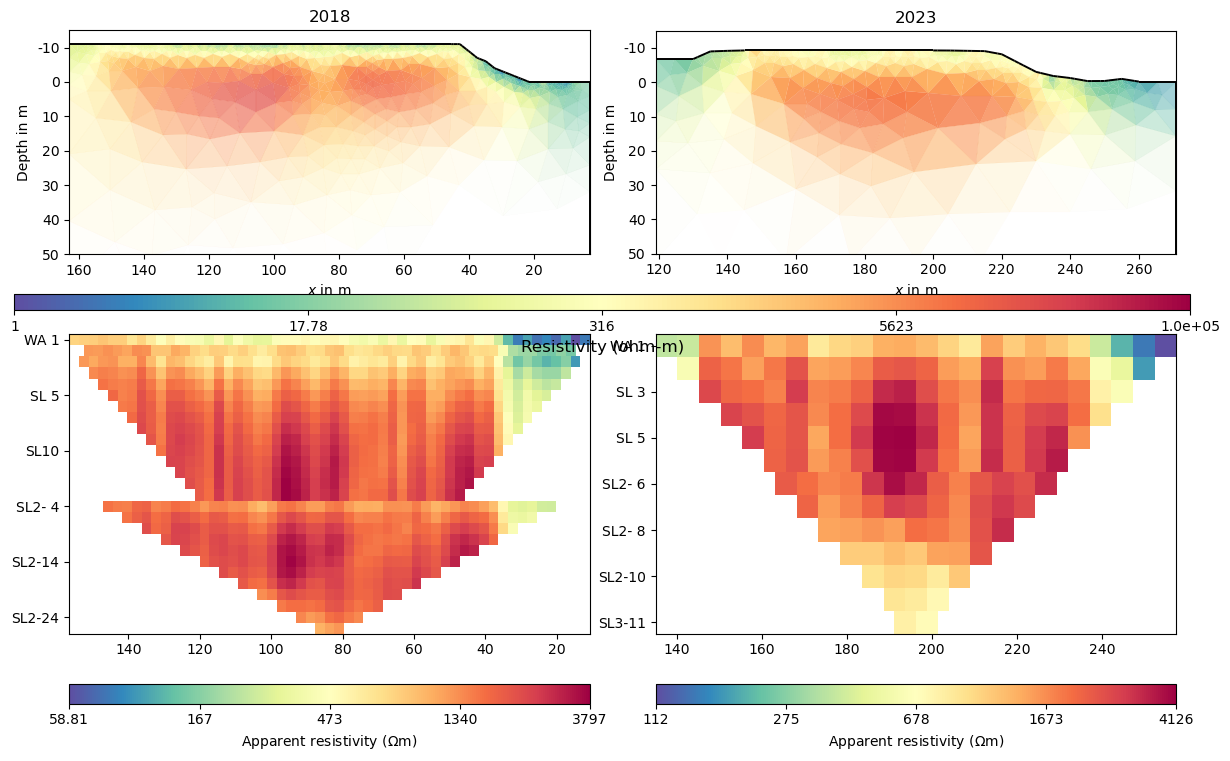

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pygimli as pg  # assuming pg is an alias for PyGIMLi
from matplotlib.ticker import MultipleLocator

data_e = ert.load(dir+"res2dinv_inputs/transects_split_in_three/amphibious_ERT_eastern_transect_gps_center.dat")
data_a = ert.load(dir+"processing/arenson/arenson_updated.dat")

#data.setSensorPositions(pg.meshtools.interpolateAlongCurve(data.additionalPoints(), pg.x(data)))
data_e['k'] = ert.createGeometricFactors(data_e, numerical=True)
mgr = ert.ERTManager(sr=False)
k0 = ert.createGeometricFactors(data_e)
data_e['err'] = ert.estimateError(data_e, relativeError=0.03, absoluteUError=5e-5)

data_a['k'] = ert.createGeometricFactors(data_a, numerical=True)
mgr = ert.ERTManager(sr=False)
k0 = ert.createGeometricFactors(data_a)
data_a['err'] = ert.estimateError(data_a, relativeError=0.03, absoluteUError=5e-5)

# Define common normalization and colormap for linear scale
cmin = 10
cmax = 100000
cmap = "Spectral_r"

# Create a 1x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Plot on the subplots with the common normalization and colormap
pg.show(mesh_arenson, res_arenson, cMap=cmap, ax=ax[0][0], colorBar=False, cMin=cmin, cMax=cmax,logScale=True, sharey = True, coverage=cov_arenson)
pg.show(mesh_eastern_center, res_eastern_center, cMap=cmap, ax=ax[0][1], colorBar=False, cMin=cmin, cMax=cmax, logScale=True, sharey = True, coverage=cov_eastern_center)
ert.showERTData(data_a, ax = ax[1][0], colorBar=True, sharey = True)
ert.showERTData(data_e, ax = ax[1][1], colorBar=True, sharey = True)

cax1 = fig.add_axes([0.01, 0.54, 0.98, 0.02])  
colorbar1 = pg.viewer.mpl.createColorBarOnly(ax=cax1, cMin=1, cMax=100000, logScale=True, cMap="Spectral_r")


ax[0][1].set_title('2023')
ax[0][0].set_title('2018')

ax[0][0].set_ylim(-50, 15)
ax[0][1].set_ylim(-50, 15)
#ax[0].set_xlim(120, 275)
#ax[1].set_xlim(0, 155)
ax[0][0].invert_xaxis()
ax[1][0].invert_xaxis()
# Set aspect ratio to equal for both subplots
#ax[0].set_aspect(2)
ax[0][0].set_aspect(1.06)

ax[0][0].xaxis.set_major_locator(MultipleLocator(20))
ax[0][0].xaxis.set_major_locator(MultipleLocator(20))

#tick_positions1 = [160, 140, 120, 100, 80, 60, 40, 20]
#tick_labels1 = ['0', '20', '40', '60', '80', '100', '120', '140']
#ax[1].set_xticks(tick_positions1)
#ax[1].set_xticklabels(tick_labels1)


#tick_positions1 = [160, 140, 120, 100, 80, 60, 40, 20]
#tick_labels1 = ['0', '20', '40', '60', '80', '100', '120', '140']
#ax[1].set_xticks(tick_positions1)
#ax[1].set_xticklabels(tick_labels1)

#cax.xaxis.set_major_locator(LogLocator(base=10.0))
#cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax1.set_xlabel('Resistivity (ohm-m)', fontsize=12)
#plt.tight_layout()  # Adjust layout to fit the colorbar
#plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9) 
plt.show()



04/08/24 - 20:54:51 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv
04/08/24 - 20:54:52 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv
04/08/24 - 20:54:52 - pyGIMLi - INFO - Cache C:\Users\mealiy001\Projects\tuk_island\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.4s x 79): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\4653169337310691530
04/08/24 - 20:54:52 - pyGIMLi - INFO - Cache C:\Users\mealiy001\Projects\tuk_island\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 79): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\982929574901384086
04/08/24 - 20:54:52 - pyGIMLi - INFO - Cache C:\Users\mealiy001\Projects\tuk_island\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (4.3s x 79): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\162931402017577431
04/08/24 - 20:54:52 - pyGIMLi - INFO - Cache C:\Users\mealiy001\Projects\tuk_island\gimli\pygimli\physics\ert\e

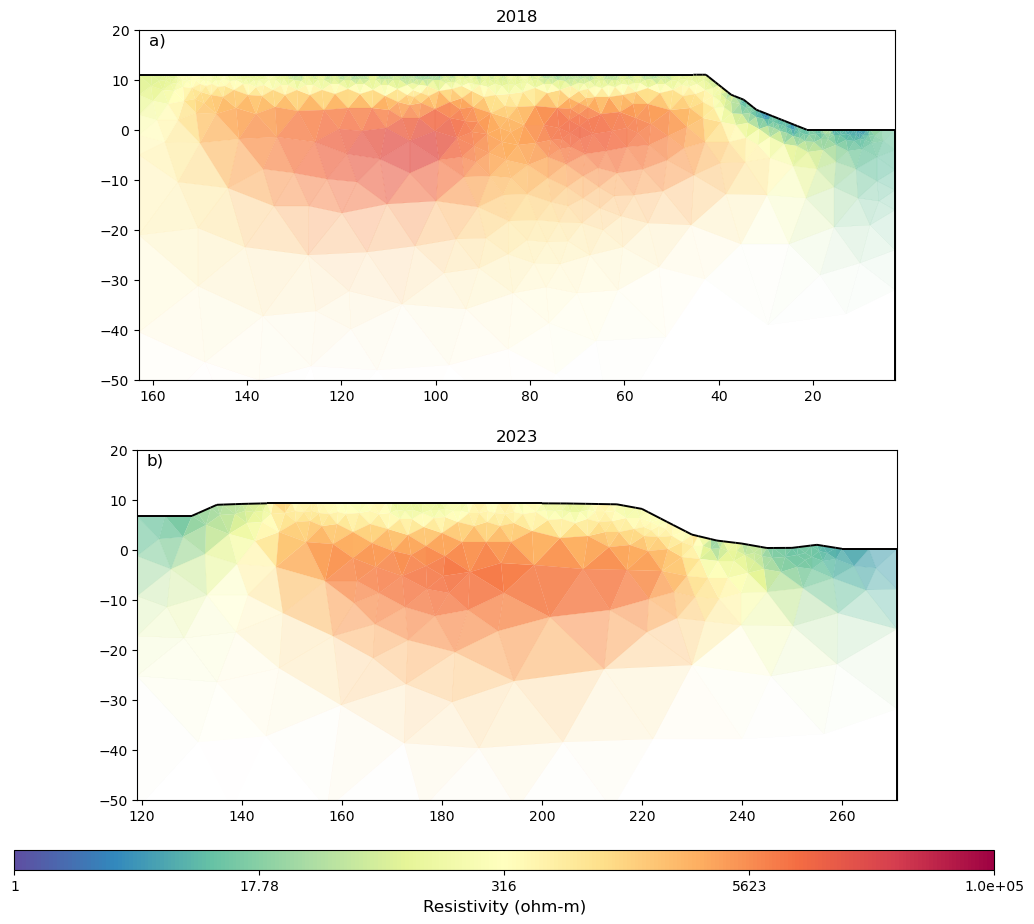

In [47]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pygimli as pg  # assuming pg is an alias for PyGIMLi
from matplotlib.ticker import MultipleLocator

data_e = ert.load(dir+"res2dinv_inputs/transects_split_in_three/amphibious_ERT_eastern_transect_gps_center.dat")
data_a = ert.load(dir+"processing/arenson/arenson_updated.dat")

#data.setSensorPositions(pg.meshtools.interpolateAlongCurve(data.additionalPoints(), pg.x(data)))
data_e['k'] = ert.createGeometricFactors(data_e, numerical=True)
mgr = ert.ERTManager(sr=False)
k0 = ert.createGeometricFactors(data_e)
data_e['err'] = ert.estimateError(data_e, relativeError=0.03, absoluteUError=5e-5)

data_a['k'] = ert.createGeometricFactors(data_a, numerical=True)
mgr = ert.ERTManager(sr=False)
k0 = ert.createGeometricFactors(data_a)
data_a['err'] = ert.estimateError(data_a, relativeError=0.03, absoluteUError=5e-5)

# Define common normalization and colormap for linear scale
cmin = 10
cmax = 100000
cmap = "Spectral_r"

# Create a 1x2 grid of subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot on the subplots with the common normalization and colormap
pg.show(mesh_arenson, res_arenson, cMap=cmap, ax=ax[0], colorBar=False, cMin=cmin, cMax=cmax,logScale=True, sharey = True, coverage=cov_arenson, axisLabels=False)
pg.show(mesh_eastern_center, res_eastern_center, cMap=cmap, ax=ax[1], colorBar=False, cMin=cmin, cMax=cmax, logScale=True, sharey = True, coverage=cov_eastern_center, axisLabels=False)


cax1 = fig.add_axes([0.01, 0.04, 0.98, 0.02])  
colorbar1 = pg.viewer.mpl.createColorBarOnly(ax=cax1, cMin=1, cMax=100000, logScale=True, cMap="Spectral_r")


ax[1].set_title('2023')
ax[0].set_title('2018')

ax[0].set_ylim(-50, 20)
ax[1].set_ylim(-50, 20)

ax[0].invert_xaxis()
#ax[1].invert_xaxis()

ax[0].set_aspect(1.06)

ax[0].xaxis.set_major_locator(MultipleLocator(20))
ax[0].xaxis.set_major_locator(MultipleLocator(20))

ax[0].text(0.035, 0.99, 'a)', transform=ax[0].transAxes, fontsize=12, va='top', ha='right')
ax[1].text(0.035, 0.99, 'b)', transform=ax[1].transAxes, fontsize=12, va='top', ha='right')

cax1.set_xlabel('Resistivity (ohm-m)', fontsize=12)

plt.show()



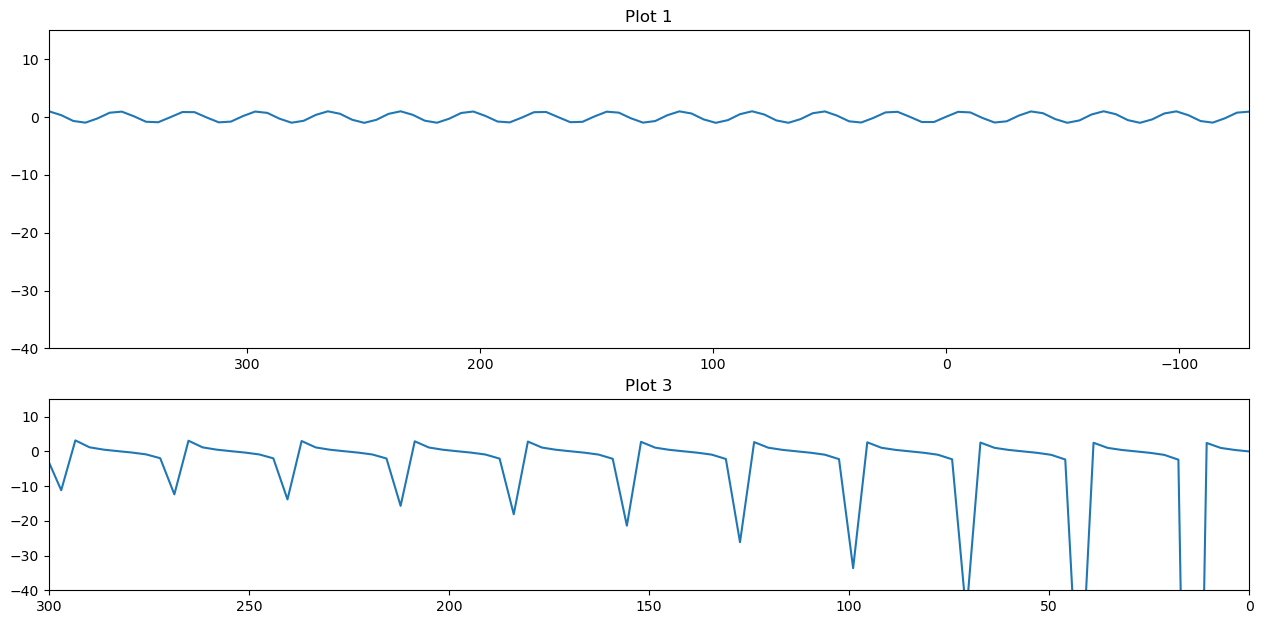

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Example data for plotting
x1 = np.linspace(385, -130, 100)
y1 = np.sin(x1)

#x2 = np.linspace(80, -120, 100)
#y2 = np.cos(x2)

x3 = np.linspace(350, 0, 100)
y3 = np.tan(x3)

# Create a figure
fig = plt.figure(figsize=(30, 14))

# Define the GridSpec layout with specified ratios
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.6])

# Create the first subplot in the first row and first column
ax0 = fig.add_subplot(gs[0])
ax0.plot(x1, y1)
ax0.set_xlim(385, -130)
ax0.set_ylim(-40, 15)
ax0.set_title('Plot 1')

# Create the second subplot in the first row and second column
#ax1 = fig.add_subplot(gs[0, 1])
#ax1.plot(x2, y2)
#ax1.set_xlim(80, -120)
#ax1.set_ylim(-40, 15)
#ax1.set_title('Plot 2')

# Adjust the width ratio for Plot 3 by specifying the width ratio when adding the subplot
#gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[0.33, 0.726, 0.33])

# Create the third subplot in the second row and first column with adjusted width ratio
ax2 = fig.add_subplot(gs[1])
#ax3 = fig.add_subplot(gs[1, 0])
#ax4 = fig.add_subplot(gs[1, 2])
#ax3.remove()
#ax4.remove()
ax2.plot(x3, y3)
ax2.set_xlim(300, 0)
ax2.set_ylim(-40, 15)
ax2.set_title('Plot 3')

fig.subplots_adjust(left=0.3, right=0.7, bottom=0.3, top=0.7)

# Get the bounding boxes of the subplots
bbox0 = ax0.get_position()
#bbox1 = ax1.get_position()
bbox2 = ax2.get_position()

# Extract the coordinates from the bounding boxes
x0_0, y0_0, width_0, height_0 = bbox0.x0, bbox0.y0, bbox0.width, bbox0.height
#x0_1, y0_1, width_1, height_1 = bbox1.x0, bbox1.y0, bbox1.width, bbox1.height
x0_2, y0_2, width_2, height_2 = bbox2.x0, bbox2.y0, bbox2.width, bbox2.height


Values in val: [(0, -0.9, 'Ice'), (-0.9, -2.4, 'Unfrozen Matter'), (-2.4, -17.6, 'Ice Bonded Permafrost')]
Values in val: [(0, -0.9, 'Ice'), (-0.9, -2.1, 'Water'), (-2.1, -5.2, 'Unfrozen Matter'), (-5.2, -14.6, 'Ice Bonded Permafrost')]


Text(0.5, 326.1222222222222, 'Resistivity (Ohm-m)')

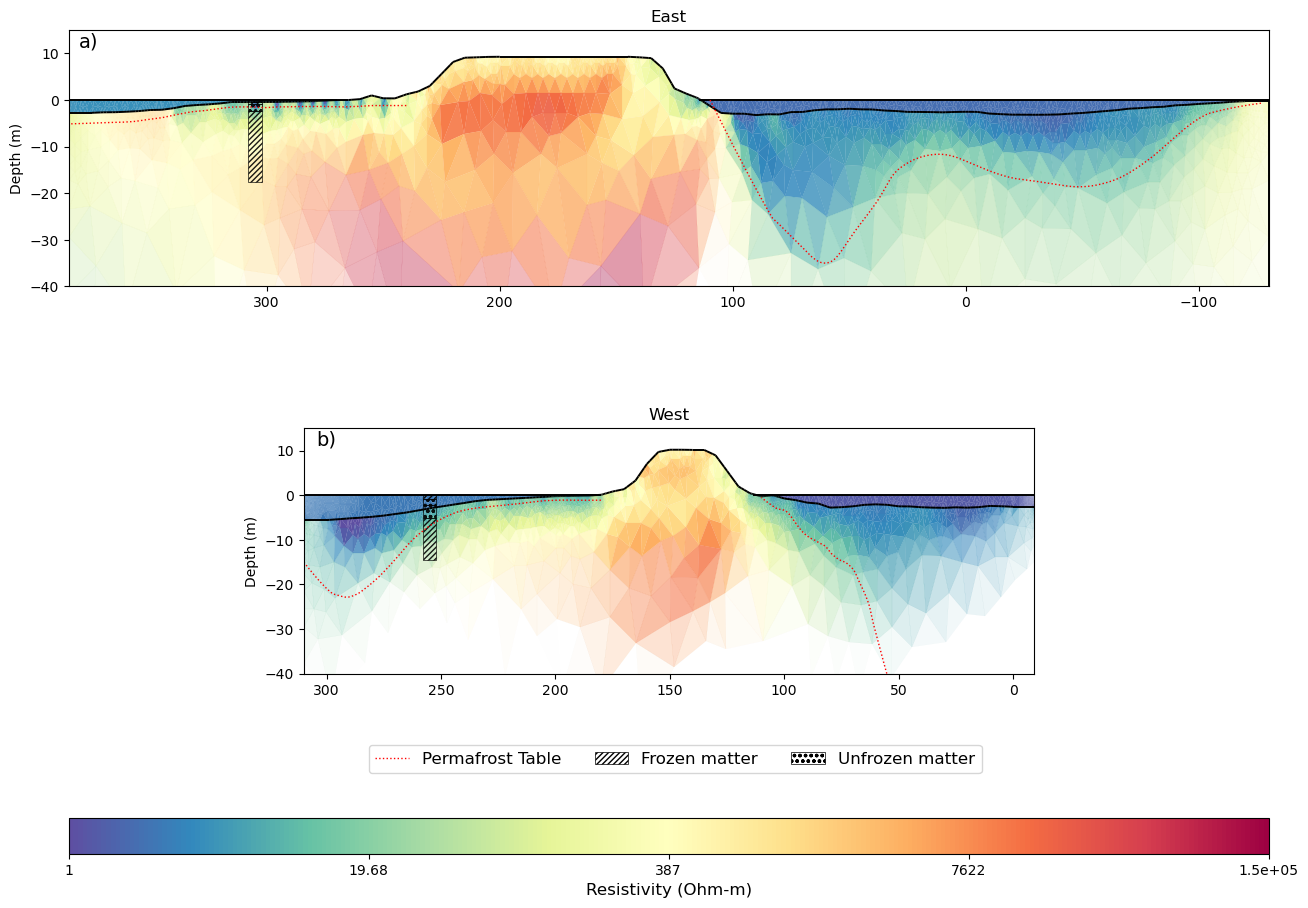

In [36]:
east_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_eastern_and_south.csv")
west_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_western.csv")

# If you need NumPy arrays
east_shore = east_shore_df.to_numpy()
west_shore = west_shore_df.to_numpy()

borehole4 = pd.read_csv(dir + "pygimli/borehole4.csv")
borehole2 = pd.read_csv(dir + "pygimli/borehole2.csv")

def draw1DColumn(ax, x, val, thk, hatch_patterns):
    print("Values in val:", val)
    bottom = 0
    for v, t in zip(val, thk):
        material_type = v[2]  
        if material_type not in hatch_patterns:
            print("Error: Hatch pattern not found for material:", v)
            continue
        hatch = hatch_patterns[material_type]
        ax.bar(x, t, bottom=bottom, width=6, edgecolor='black', alpha=0.9, facecolor='none', hatch=hatch, linewidth=0.5)
        bottom += t


borehole2_data = [(0, -0.9, 'Ice'), (-0.9, -2.1, 'Water'), (-2.1, -5.2, 'Unfrozen Matter'), (-5.2, -14.6, 'Ice Bonded Permafrost')]
borehole4_data = [(0, -0.9, 'Ice'), (-0.9, -2.4, 'Unfrozen Matter'), (-2.4, -17.6, 'Ice Bonded Permafrost')]

hatch_patterns = {'Ice': '//////', 'Water': 'ooo', 'Unfrozen Matter': 'ooo', 'Ice Bonded Permafrost': '//////'}

AL_e = np.loadtxt(dir + "pygimli/AL_eastern.txt")
AL_w = np.loadtxt(dir + "pygimli/AL_western.txt")

e_permafrost_table1 = np.load(dir+ 'pygimli/eastern_perm_table1.npy')
e_permafrost_table_smooth1 = np.load(dir+ 'pygimli/eastern_perm_table_smooth1.npy')
e_permafrost_table_x1 = np.load(dir+ 'pygimli/eastern_perm_table_x1.npy')

e_permafrost_table2 = np.load(dir+ 'pygimli/eastern_perm_table2.npy')
e_permafrost_table_smooth2 = np.load(dir+ 'pygimli/eastern_perm_table_smooth2.npy')
e_permafrost_table_x2 = np.load(dir+ 'pygimli/eastern_perm_table_x2.npy')

s_permafrost_table = np.load(dir+ 'pygimli/southeast_perm_table.npy')
s_permafrost_table_smooth = np.load(dir+ 'pygimli/southeast_perm_table_smooth.npy')
s_permafrost_table_x = np.load(dir+ 'pygimli/southeast_perm_table_x.npy')

w_permafrost_table1 = np.load(dir+ 'pygimli/western_perm_table1.npy')
w_permafrost_table_smooth1 = np.load(dir+ 'pygimli/western_perm_table_smooth1.npy')
w_permafrost_table_x1 = np.load(dir+ 'pygimli/western_perm_table_x1.npy')

w_permafrost_table2 = np.load(dir+ 'pygimli/western_perm_table2.npy')
w_permafrost_table_smooth2 = np.load(dir+ 'pygimli/western_perm_table_smooth2.npy')
w_permafrost_table_x2 = np.load(dir+ 'pygimli/western_perm_table_x2.npy')

x_AL_e = AL_e[0]
z_AL_e = AL_e[1]
x_AL_w = AL_w[0]
z_AL_w = AL_w[1]

fig, ax = plt.subplots(2, 1, figsize=(30, 18))
ax0 = ax[0]
#ax1 = ax[0,1]
ax2 = ax[1]
#ax_bottom = ax[1, 1]
#ax_bottom.remove()

pg.show(mesh_eastern, res_eastern,sharey=True, logScale=True, cMap="Spectral_r", ax=ax0, colorBar=False, cMin=1, cMax=150000, coverage=cov_eastern, axisLabels=False)
#pg.show(mesh_southeast, res_southeast,  logScale=True, sharey=True, cMap="Spectral_r", ax=ax1, colorBar=False, cMin=1, cMax=100000, coverage=cov_southeast)
pg.show(mesh_western, res_western, sharey=True, logScale=True, cMap="Spectral_r", ax=ax2, colorBar=False, cMin=1, cMax=150000, coverage=cov_western, axisLabels=False)


ax0.set_ylim(-40, 15)
ax0.set_ylabel("Depth (m)")
#ax0.set_xlim()
#ax1.set_ylim(-40, 15)
#ax1.set_xlim(-120, 80)
ax2.set_ylim(-40, 15)
ax2.set_xlim(-9)

ax0.set_title('East')
#ax1.set_title('Southeast')
ax2.set_title('West')
ax2.set_ylabel("Depth (m)")

ax0.set_position([x0_0, y0_0, width_0, height_0])
#ax1.set_position([x0_1, y0_1, width_1, height_1])
ax2.set_position([x0_2, y0_2, width_2, height_2])

ax0.set_aspect(2)
#ax1.set_aspect(1.9)
ax2.set_aspect(1.95)

ax0.invert_xaxis()
#ax1.invert_xaxis()
ax2.invert_xaxis()

draw1DColumn(ax0, 305, borehole4_data, [item[1] - item[0] for item in borehole4_data], hatch_patterns)
draw1DColumn(ax2, 255, borehole2_data, [item[1] - item[0] for item in borehole2_data], hatch_patterns)


line1, = ax0.plot(e_permafrost_table_x1, e_permafrost_table_smooth1, ":", linewidth=1, color='red', label='Permafrost Table')
line2, = ax0.plot(e_permafrost_table_x2, e_permafrost_table_smooth2, ":", linewidth=1, color='red')
#line3, = ax1.plot(s_permafrost_table_x, s_permafrost_table_smooth, ":", linewidth=1, color='red')
line4, = ax2.plot(w_permafrost_table_x1, w_permafrost_table_smooth1, ":", linewidth=1, color='red')
line5, = ax2.plot(w_permafrost_table_x2, w_permafrost_table_smooth2, ":", linewidth=1, color='red')
#vline1 = ax0.axvline(x=80, color='gray', linestyle='-', linewidth=0.1, label='_nolegend_')
#vline2 = ax1.axvline(x=-10, color='gray', linestyle='-', linewidth=0.1, label='_nolegend_')
#ax0.add_patch(Rectangle((80, -40), -90, 55, linewidth=0.1, edgecolor='black', facecolor='gray', alpha=0.15, label='East and Southeast overlap'))
#ax1.add_patch(Rectangle((80, -40), -90, 55, linewidth=0.1, edgecolor='black', facecolor='gray', alpha=0.15))
#ax1.xaxis.set_major_locator(MultipleLocator(50))
#ax0.plot(x_AL_e, z_AL_e, 'g_', linewidth=1)
#ax2.plot(x_AL_w, z_AL_w, 'g_', linewidth=1)

hatch_patterns = {'Frozen matter': '//////', 'Unfrozen matter': 'ooo'}
handles, labels = ax0.get_legend_handles_labels()
legend_patches = [Rectangle((0, 0), 1, 1, fc='none', ec='black', lw=0.5, hatch=hatch_patterns[mat]) for mat in hatch_patterns]
#extended_symbol_patch = plt.Line2D([0, 0.5], [0, 0], color='g', linewidth=0.5)
all_handles = handles + legend_patches 
#ax0.legend(handles=all_handles, labels=labels + list(hatch_patterns.keys()) + ['Active Layer Probe'], loc=(0.43, -2.6), fontsize=8, ncol=2)
#ax2.legend(handles=all_handles, labels=labels + list(hatch_patterns.keys()), loc='center', fontsize=10, ncol=3)
ax0.legend(handles=all_handles, labels=labels + list(hatch_patterns.keys()), loc=(0.25, -1.9), fontsize=12, ncol=3)
cax = fig.add_axes([0.3, 0.2, 0.4, 0.02])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, cMin=1, cMax=150000, logScale=True, cMap="Spectral_r")
ax0.text(0.025, 0.99, 'a)', transform=ax0.transAxes, fontsize=14, va='top', ha='right')
ax2.text(0.045, 0.99, 'b)', transform=ax2.transAxes, fontsize=14, va='top', ha='right')

#plt.subplots_adjust(hspace=0)
#cax.xaxis.set_major_locator(LogLocator(base=10.0))
#cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Resistivity (Ohm-m)', fontsize=12)

hoevmueller With historical shoreline positions

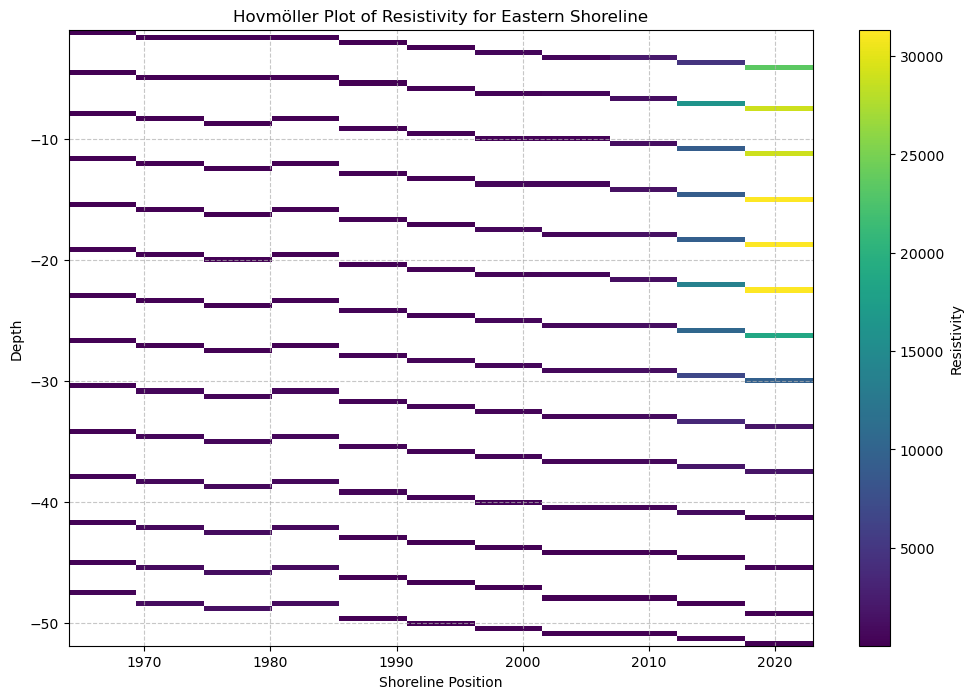

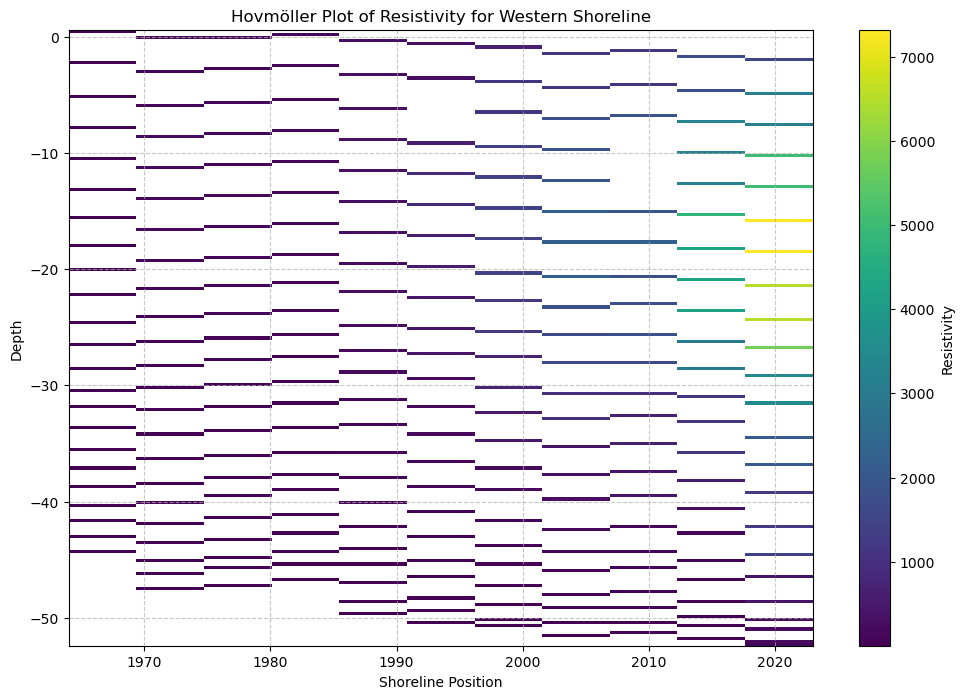

In [86]:
east_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_eastern_and_south.csv")
west_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_western.csv")

# If you need NumPy arrays
east_shore = east_shore_df.to_numpy()
west_shore = west_shore_df.to_numpy()

def preprocess_data(data):
    # Extract columns
    x_positions = data[:, 3]
    depths = data[:, 1]
    resistivity = data[:, 2]
    
    # Get unique x positions and depths
    unique_x = np.unique(x_positions)
    unique_depths = np.unique(depths)
    
    # Initialize the resistivity matrix
    resistivity_matrix = np.full((len(unique_x), len(unique_depths)), np.nan)

    for i, x in enumerate(unique_x):
        for j, depth in enumerate(unique_depths):
            # Get the resistivity value at this (x, depth) combination
            mask = (x_positions == x) & (depths == depth)
            if np.any(mask):
                # Take the average if there are multiple readings
                resistivity_matrix[i, j] = np.mean(resistivity[mask])
    
    return unique_x, unique_depths, resistivity_matrix

# Process east and west shore datasets
east_x_positions, east_depths, east_resistivity = preprocess_data(east_shore)
west_x_positions, west_depths, west_resistivity = preprocess_data(west_shore)

# Plotting for the east shore
plt.figure(figsize=(12, 8))
plt.imshow(east_resistivity.T, aspect='auto', extent=[east_x_positions.min(), east_x_positions.max(), east_depths.min(), east_depths.max()], cmap='viridis')
plt.colorbar(label='Resistivity')
plt.xlabel('Shoreline Position')
plt.ylabel('Depth')
plt.title('Hovmöller Plot of Resistivity for Eastern Shoreline')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plotting for the west shore
plt.figure(figsize=(12, 8))
plt.imshow(west_resistivity.T, aspect='auto', extent=[west_x_positions.min(), west_x_positions.max(), west_depths.min(), west_depths.max()], cmap='viridis')
plt.colorbar(label='Resistivity')
plt.xlabel('Shoreline Position')
plt.ylabel('Depth')
plt.title('Hovmöller Plot of Resistivity for Western Shoreline')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

With historical shoreline positions 

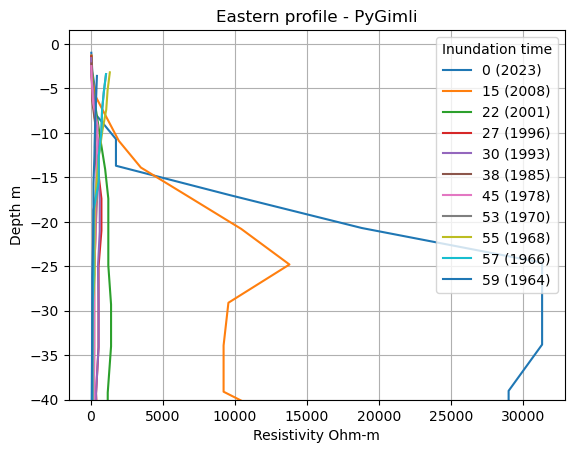

In [49]:
east_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_eastern_and_south.csv")
west_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_western.csv")

# If you need NumPy arrays
east_shore = east_shore_df.to_numpy()
west_shore = west_shore_df.to_numpy()


years = np.unique(east_shore[:, 4])

# Plotting each year's resistivity values with depth
for year in years:
    # Selecting data for the current year
    data_year = east_shore[east_shore[:, 4] == year]
    data_year_time = east_shore[east_shore[:, 3] == year]
    # Sorting the data based on depth
    
    # Plotting
    plt.plot(data_year[:, 2], data_year[:, 1], label=str(int(year)) + f' ({int(2023 - year)})')

# Adding labels and legend
plt.ylabel('Depth m')
plt.ylim(-40)
plt.xlabel('Resistivity Ohm-m')
plt.title('Eastern profile - PyGimli')
plt.legend(title='Inundation time')
plt.grid(True)
plt.show()

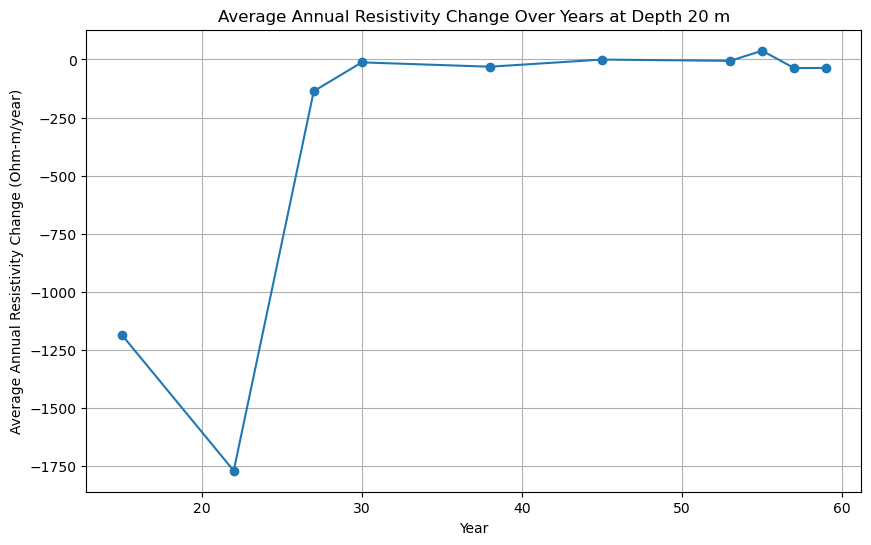

[-1183.22612526843,
 -1768.699893258092,
 -136.5753501638467,
 -12.803460446178955,
 -31.45498669602225,
 -0.7829329487712512,
 -6.339904902159741,
 37.27142994296548,
 -37.27142994296548,
 -36.88300277140588]

In [50]:
years = np.unique(east_shore[:, 4])

# Prepare a list to store the results
results = []

for year in years:
    # Select data for the current year
    data_year = east_shore[east_shore[:, 4] == year]
    
    if len(data_year) > 0:
        # Sort the data based on depth
        data_year = data_year[np.argsort(data_year[:, 1])]
        
        # Interpolate for depth -20m
        depths = data_year[:, 1]
        resistivities = data_year[:, 2]
        
        # Create interpolation function
        interp_func = interp1d(depths, resistivities, kind='linear', fill_value='extrapolate')
        
        # Interpolate at depth -20m
        resistivity_at_20m = interp_func(-25)
        
        # Store the result
        results.append({'Year': year, 'Resistivity_at_-20m': resistivity_at_20m})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

change_list = []
years_between = []

for i in range(len(results_df) - 1):
    year1 = results_df.iloc[i]['Year']
    year2 = results_df.iloc[i + 1]['Year']
    resistivity1 = results_df.iloc[i]['Resistivity_at_-20m']
    resistivity2 = results_df.iloc[i + 1]['Resistivity_at_-20m']
    
    change = resistivity2 - resistivity1
    years_between.append(year2 - year1)
    change_list.append(change / (year2 - year1))

# Ensure lengths are consistent
if len(change_list) == len(results_df) - 1:
    # Create DataFrame for plotting
    change_df = pd.DataFrame({
        'Start_Year': results_df['Year'].iloc[:-1].values,
        'End_Year': results_df['Year'].iloc[1:].values,
        'Average_Annual_Change': change_list
    })
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(change_df['End_Year'], change_df['Average_Annual_Change'], marker='o', linestyle='-')
    plt.xlabel('Year')
    plt.ylabel('Average Annual Resistivity Change (Ohm-m/year)')
    plt.title('Average Annual Resistivity Change Over Years at Depth 20 m')
    plt.grid(True)
    plt.show()

change_list

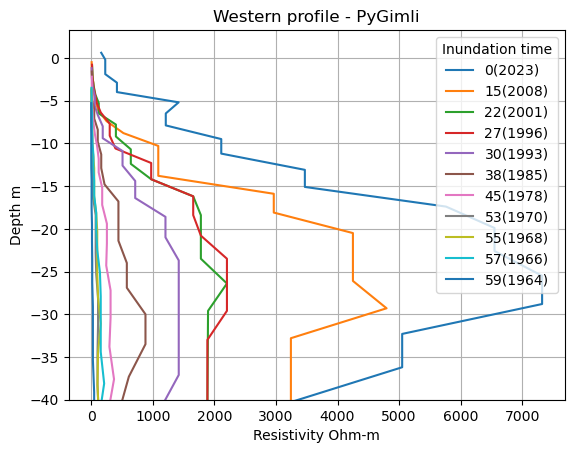

In [20]:
years = np.unique(west_shore[:, 4])

# Plotting each year's resistivity values with depth
for year in years:
    # Selecting data for the current year
    data_year = west_shore[west_shore[:, 4] == year]
    data_year_time = west_shore[west_shore[:, 3] == year]
    # Sorting the data based on depth
    
    # Plotting
    plt.plot(data_year[:, 2], data_year[:, 1], label=str(int(year)) + f'({int(2023 - year)})')

# Adding labels and legend
plt.ylabel('Depth m')
plt.ylim(-40)
plt.xlabel('Resistivity Ohm-m')
plt.title('Western profile - PyGimli')
plt.legend(title='Inundation time')
plt.grid(True)
plt.show()

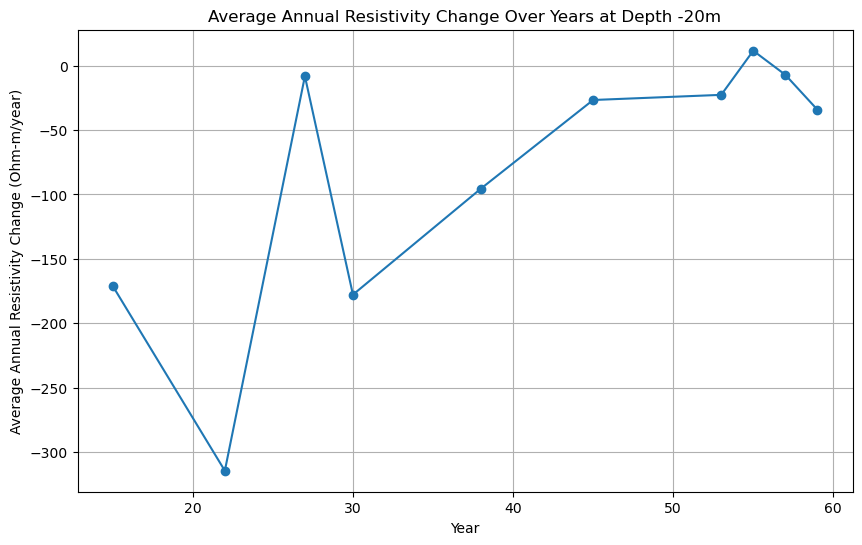

[-171.05508419474134,
 -314.3504543681446,
 -8.288605901040228,
 -177.76801335193144,
 -95.42657041038396,
 -26.74643753528424,
 -22.75473026645605,
 11.480631220318024,
 -7.171239785909123,
 -34.17818144127074]

In [23]:
years = np.unique(east_shore[:, 4])

# Prepare a list to store the results
results = []

for year in years:
    # Select data for the current year
    data_year = west_shore[west_shore[:, 4] == year]
    
    if len(data_year) > 0:
        # Sort the data based on depth
        data_year = data_year[np.argsort(data_year[:, 1])]
        
        # Interpolate for depth -20m
        depths = data_year[:, 1]
        resistivities = data_year[:, 2]
        
        # Create interpolation function
        interp_func = interp1d(depths, resistivities, kind='linear', fill_value='extrapolate')
        
        # Interpolate at depth -20m
        resistivity_at_20m = interp_func(-20)
        
        # Store the result
        results.append({'Year': year, 'Resistivity_at_-20m': resistivity_at_20m})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

change_list = []
years_between = []

for i in range(len(results_df) - 1):
    year1 = results_df.iloc[i]['Year']
    year2 = results_df.iloc[i + 1]['Year']
    resistivity1 = results_df.iloc[i]['Resistivity_at_-20m']
    resistivity2 = results_df.iloc[i + 1]['Resistivity_at_-20m']
    
    change = resistivity2 - resistivity1
    years_between.append(year2 - year1)
    change_list.append(change / (year2 - year1))

# Ensure lengths are consistent
if len(change_list) == len(results_df) - 1:
    # Create DataFrame for plotting
    change_df = pd.DataFrame({
        'Start_Year': results_df['Year'].iloc[:-1].values,
        'End_Year': results_df['Year'].iloc[1:].values,
        'Average_Annual_Change': change_list
    })
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(change_df['End_Year'], change_df['Average_Annual_Change'], marker='o', linestyle='-')
    plt.xlabel('Year')
    plt.ylabel('Average Annual Resistivity Change (Ohm-m/year)')
    plt.title('Average Annual Resistivity Change Over Years at Depth -20m')
    plt.grid(True)
    plt.show()

change_list


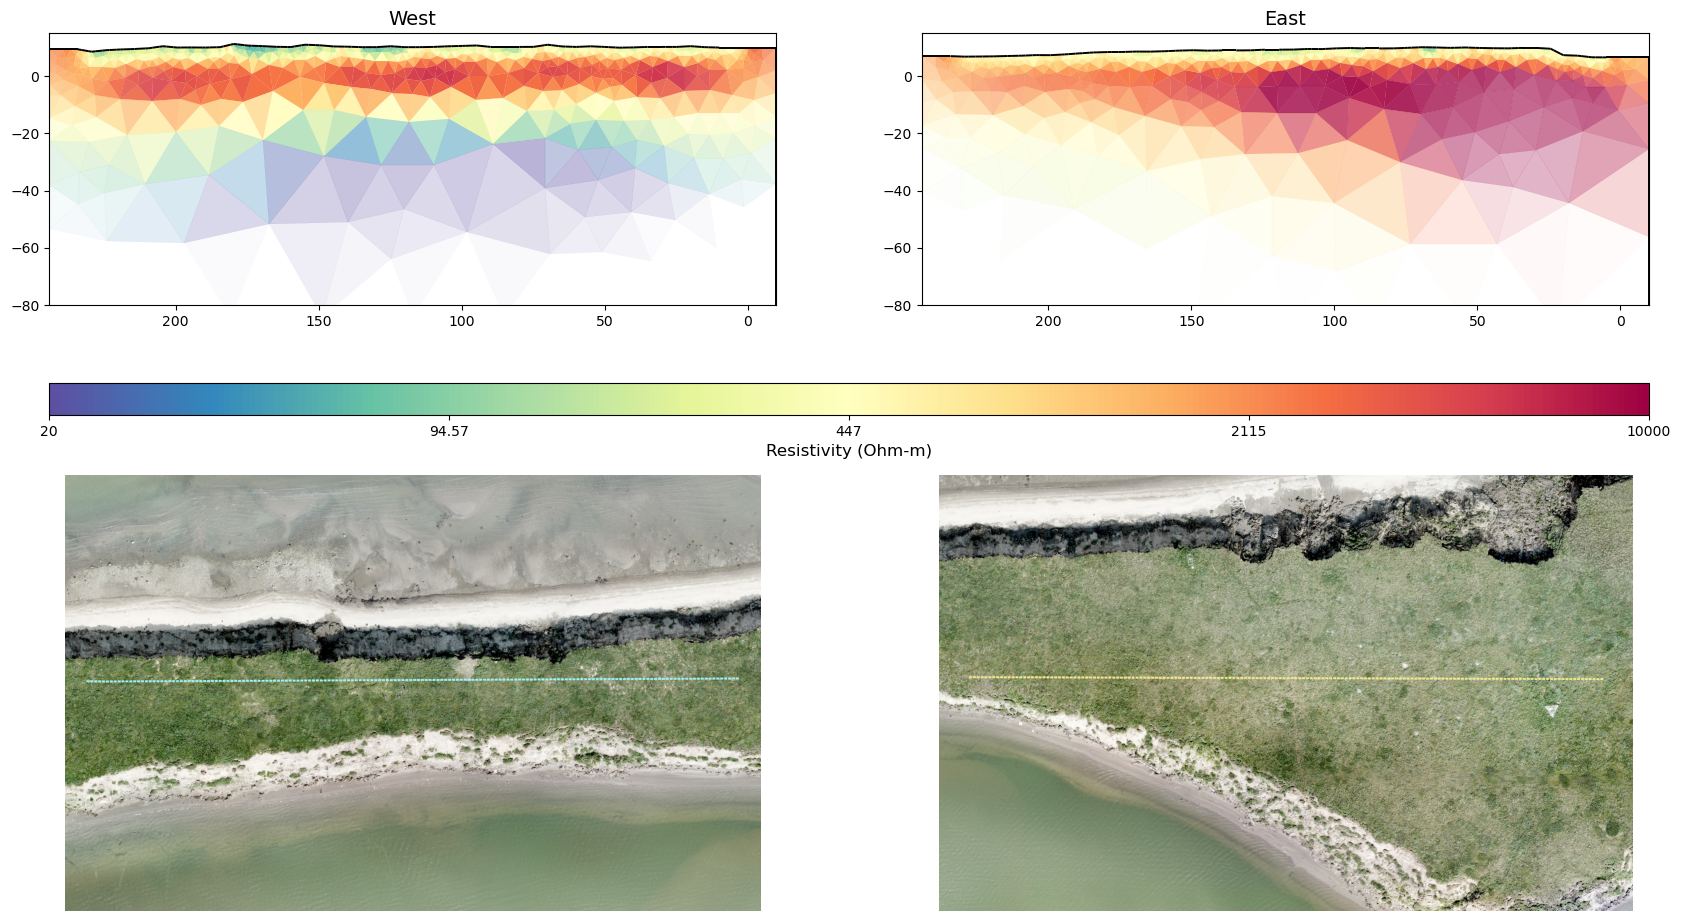

In [883]:
img_eastern = mpimg.imread(dir+'paper/figures/eastgis1.png')
img_western = mpimg.imread(dir+'paper/figures/westgis1.png')


AL_e = np.loadtxt(dir + "pygimli/AL_eastern_parallel_to_shore.txt")
AL_w = np.loadtxt(dir + "pygimli/AL_western_parallel_to_shore.txt")

x_AL_e = AL_e[:, 0]
z_AL_e = AL_e[:, 1]
x_AL_w = AL_w[:, 0]
z_AL_w = AL_w[:, 1]

fig, ax = plt.subplots(2, 2, figsize=(20, 16))

cax = fig.add_axes([0.1, 0.51, 0.8, 0.02])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, logScale=True, cMin=20, cMax=10000,cMap="Spectral_r")

pg.show(mesh_western_perpendicular, res_western_perpendicular, cMap=cmap, ax=ax[0][0], colorBar=False, logScale=True, cMin=100, cMax=10000, sharey = True, coverage=cov_western_perpendicular)
pg.show(mesh_eastern_perpendicular, res_eastern_perpendicular, cMap=cmap, ax=ax[0][1], colorBar=False,logScale=True, cMin=100, cMax=10000, sharey = True, coverage=cov_eastern_perpendicular)

ax[0][0].invert_xaxis()
ax[0][1].invert_xaxis()

ax[1][1].imshow(img_eastern)
ax[1][1].axis('off')  


ax[1][0].imshow(img_western)
ax[1][0].axis('off')  

ax[0][0].set_title('West', fontsize=14)
ax[0][1].set_title('East', fontsize=14)

ax[0][0].set_ylim(-80, 15)
ax[0][1].set_ylim(-80, 15)
#ax[0][0].plot(x_AL_w, z_AL_w, 'r--', linewidth=2)
#ax[0][1].plot(x_AL_e, z_AL_e, 'r--', linewidth=2)

cax.set_xlabel('Resistivity (Ohm-m)', fontsize=12)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8) 

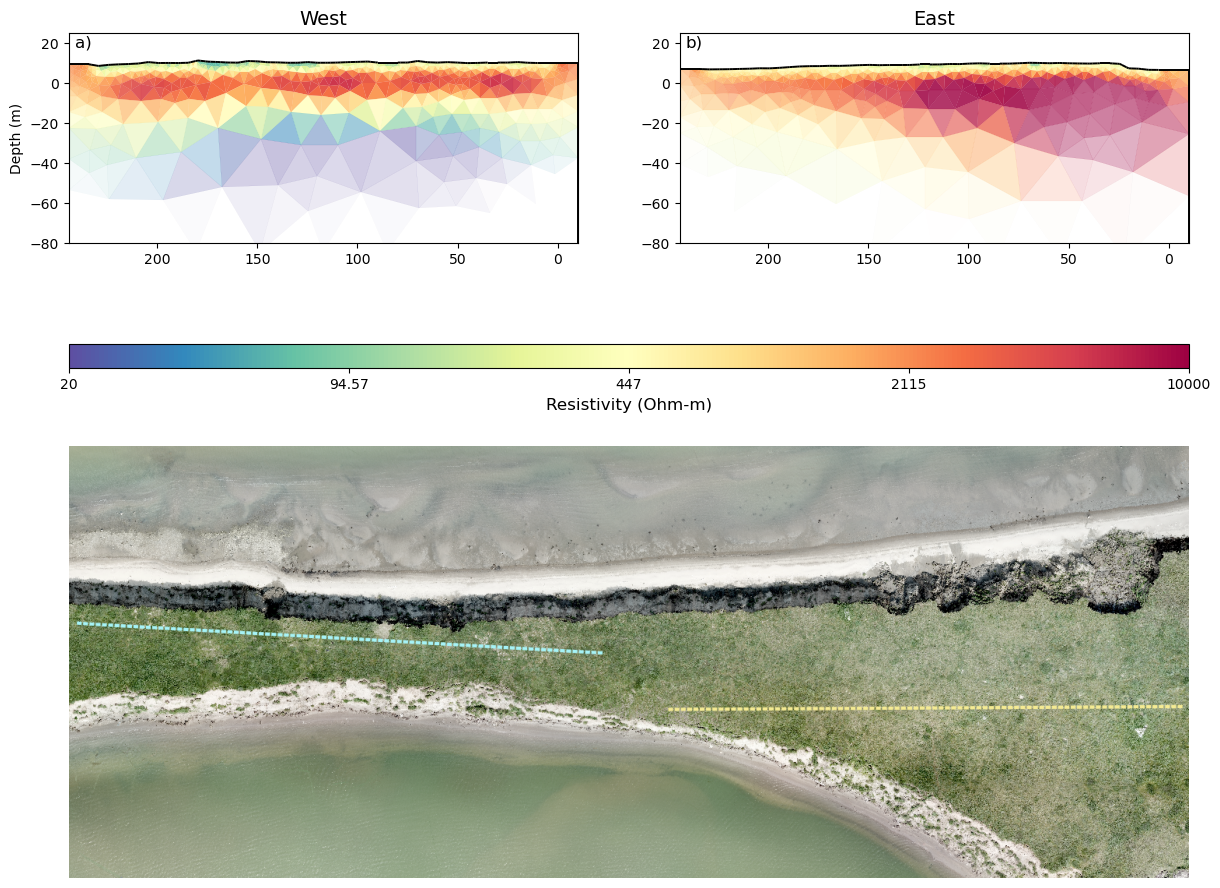

In [115]:
#img_eastern = mpimg.imread(dir+'paper/figures/eastgis1.png')
#img_western = mpimg.imread(dir+'paper/figures/westgis1.png')
img = mpimg.imread(dir+'paper/figures/bothgis.png')

AL_e = np.loadtxt(dir + "pygimli/AL_eastern_parallel_to_shore.txt")
AL_w = np.loadtxt(dir + "pygimli/AL_western_parallel_to_shore.txt")

x_AL_e = AL_e[:, 0]
z_AL_e = AL_e[:, 1]
x_AL_w = AL_w[:, 0]
z_AL_w = AL_w[:, 1]

fig = plt.figure(figsize=(14, 16))
gs = gridspec.GridSpec(2, 2)

# Create the first subplot in the first row and first column
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])

cax = fig.add_axes([0.1, 0.52, 0.8, 0.015])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, logScale=True, cMin=20, cMax=10000,cMap="Spectral_r")

pg.show(mesh_western_perpendicular, res_western_perpendicular, cMap=cmap, ax=ax0, colorBar=False, logScale=True, cMin=100, cMax=10000, sharey = True, coverage=cov_western_perpendicular, axisLabels=False)
pg.show(mesh_eastern_perpendicular, res_eastern_perpendicular, cMap=cmap, ax=ax1, colorBar=False,logScale=True, cMin=100, cMax=10000, sharey = True, coverage=cov_eastern_perpendicular, axisLabels=False)

ax0.invert_xaxis()
ax1.invert_xaxis()

#ax[1][1].imshow(img_eastern)
#ax[1][1].axis('off')  


ax2.imshow(img)
ax2.axis('off')  

ax0.set_ylabel('Depth (m)')
ax0.set_title('West', fontsize=14)
ax1.set_title('East', fontsize=14)

ax0.set_ylim(-80, 25)
ax1.set_ylim(-80, 25)
#ax[0][0].plot(x_AL_w, z_AL_w, 'r--', linewidth=2)
#ax[0][1].plot(x_AL_e, z_AL_e, 'r--', linewidth=2)

ax0.text(0.045, 0.99, 'a)', transform=ax0.transAxes, fontsize=12, va='top', ha='right')
ax1.text(0.045, 0.99, 'b)', transform=ax1.transAxes, fontsize=12, va='top', ha='right')

cax.set_xlabel('Resistivity (Ohm-m)', fontsize=12)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8) 

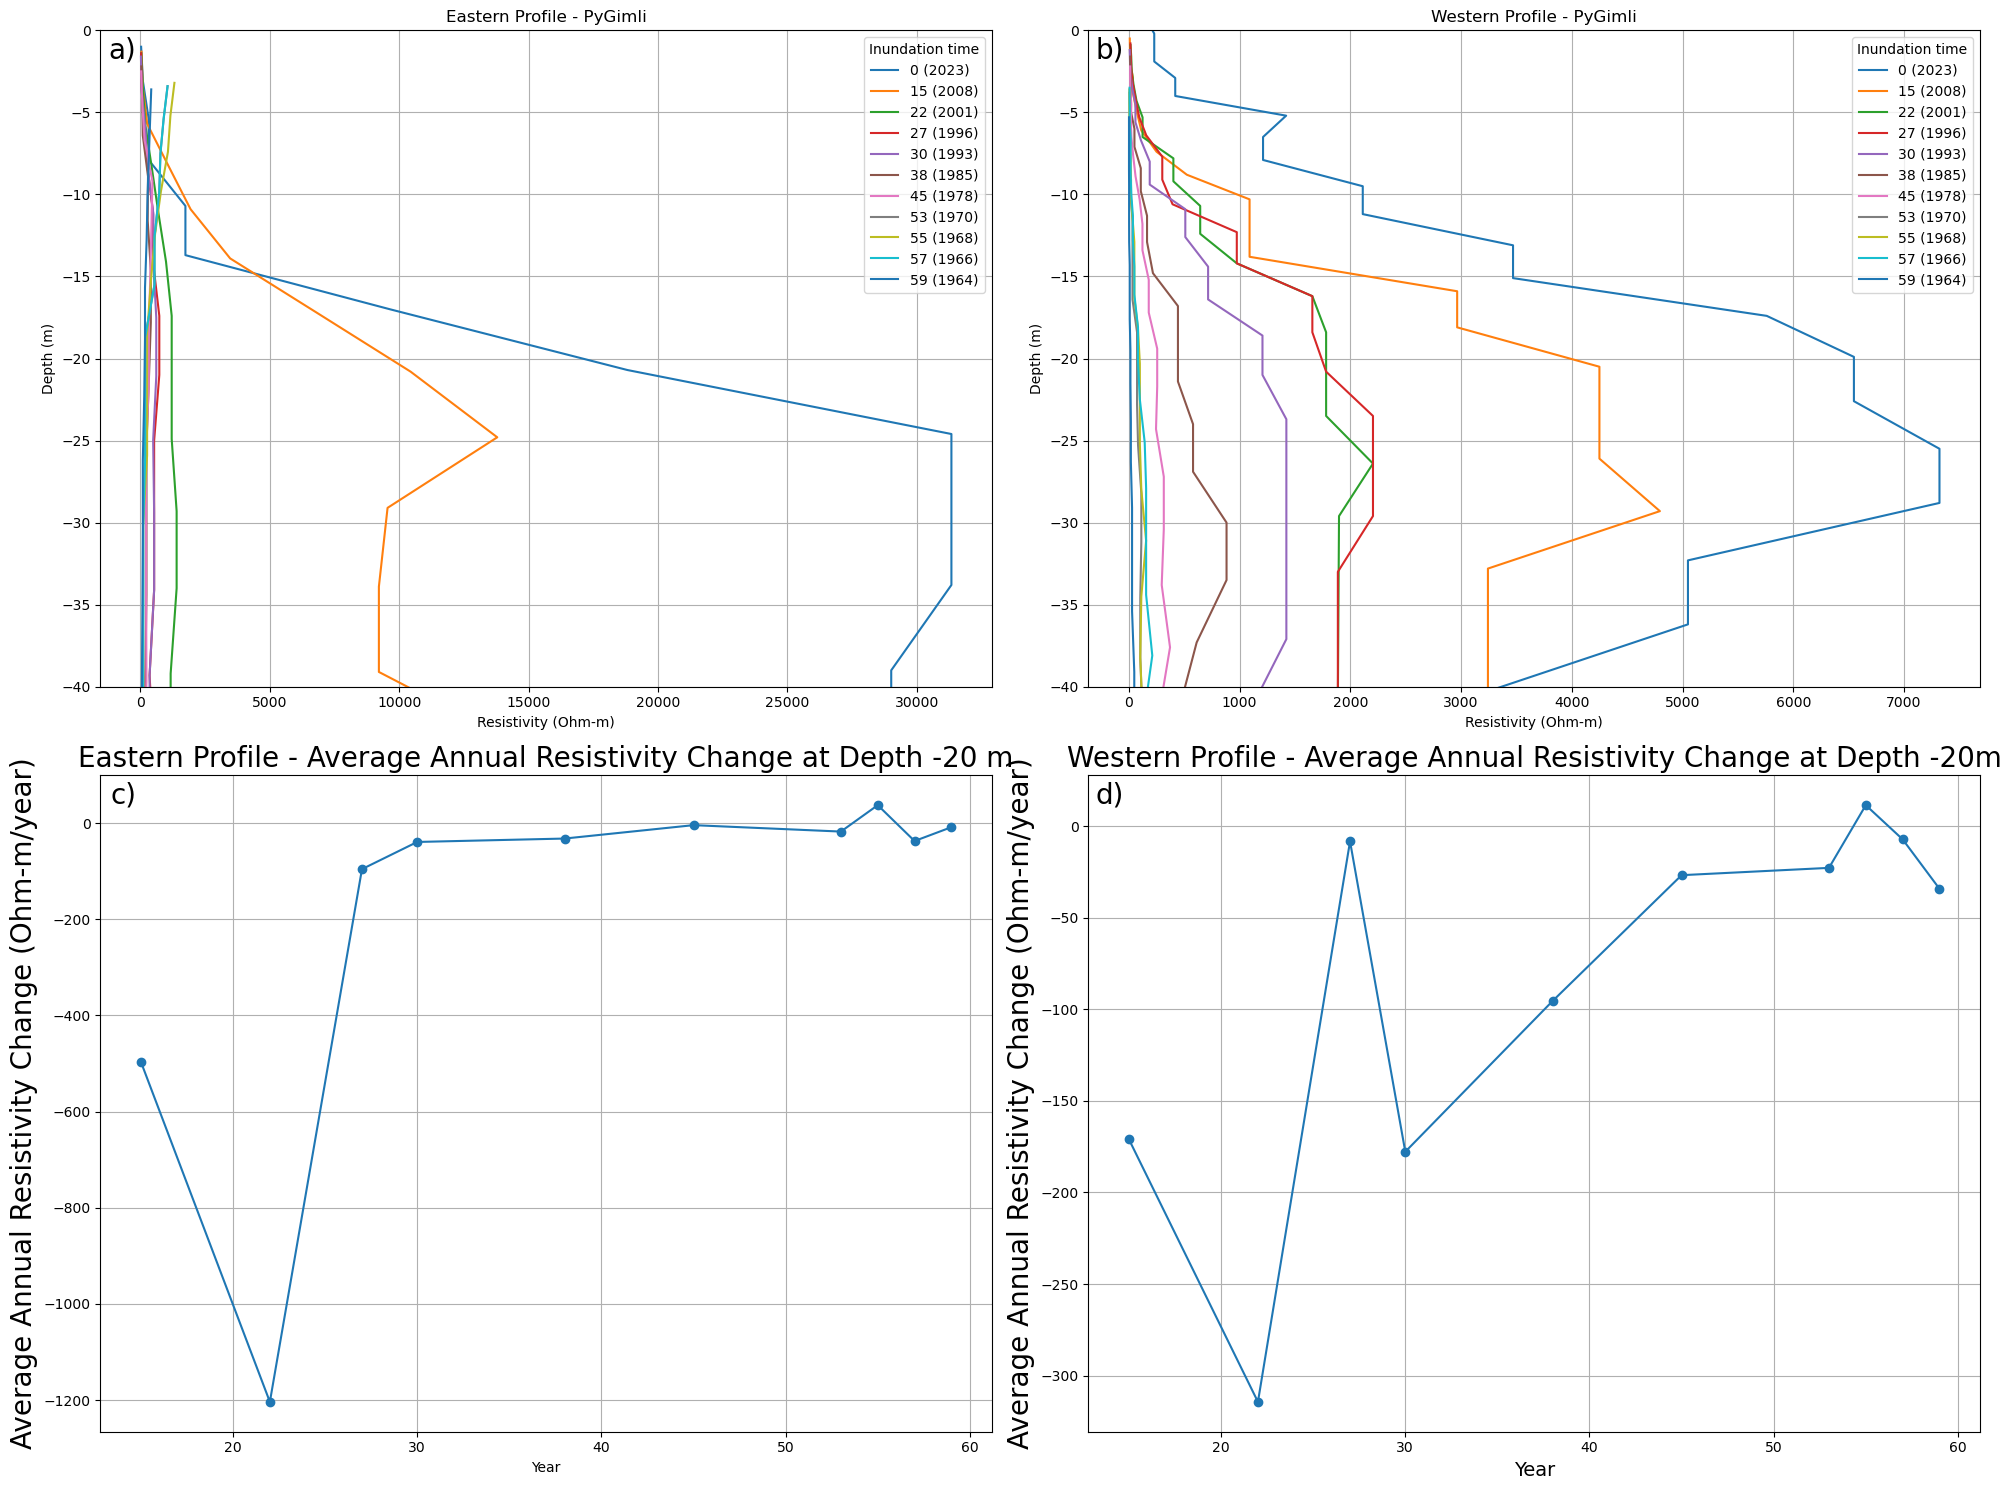

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Load data
east_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_eastern_and_south.csv")
west_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_western.csv")

east_shore = east_shore_df.to_numpy()
west_shore = west_shore_df.to_numpy()

# Unique years for both profiles
years_east = np.unique(east_shore[:, 4])
years_west = np.unique(west_shore[:, 4])

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax0, ax1 = ax[0]
ax2, ax3 = ax[1]

# Eastern profile resistivity vs. depth
for year in years_east:
    data_year = east_shore[east_shore[:, 4] == year]
    ax0.plot(data_year[:, 2], data_year[:, 1], label=str(int(year)) + f' ({int(2023 - year)})')

ax0.set_ylabel('Depth (m)')
ax0.set_ylim(-40, 0)
ax0.set_xlabel('Resistivity (Ohm-m)')
ax0.set_title('Eastern Profile - PyGimli')
ax0.legend(title='Inundation time')
ax0.grid(True)

# Western profile resistivity vs. depth
for year in years_west:
    data_year = west_shore[west_shore[:, 4] == year]
    ax1.plot(data_year[:, 2], data_year[:, 1], label=str(int(year)) + f' ({int(2023 - year)})')

ax1.set_ylabel('Depth (m)')
ax1.set_ylim(-40, 0)
ax1.set_xlabel('Resistivity (Ohm-m)')
ax1.set_title('Western Profile - PyGimli')
ax1.legend(title='Inundation time')
ax1.grid(True)

# Eastern profile - Average annual resistivity change at depth -25m
results_east = []
for year in years_east:
    data_year = east_shore[east_shore[:, 4] == year]
    if len(data_year) > 0:
        data_year = data_year[np.argsort(data_year[:, 1])]
        depths = data_year[:, 1]
        resistivities = data_year[:, 2]
        interp_func = interp1d(depths, resistivities, kind='linear', fill_value='extrapolate')
        resistivity_at_20m = interp_func(-20)
        results_east.append({'Year': year, 'Resistivity_at_-20m': resistivity_at_20m})

results_df_east = pd.DataFrame(results_east)

change_list_east = []
for i in range(len(results_df_east) - 1):
    year1 = results_df_east.iloc[i]['Year']
    year2 = results_df_east.iloc[i + 1]['Year']
    resistivity1 = results_df_east.iloc[i]['Resistivity_at_-20m']
    resistivity2 = results_df_east.iloc[i + 1]['Resistivity_at_-20m']
    change = resistivity2 - resistivity1
    change_list_east.append(change / (year2 - year1))

change_df_east = pd.DataFrame({
    'Start_Year': results_df_east['Year'].iloc[:-1].values,
    'End_Year': results_df_east['Year'].iloc[1:].values,
    'Average_Annual_Change': change_list_east
})

ax2.plot(change_df_east['End_Year'], change_df_east['Average_Annual_Change'], marker='o', linestyle='-')
ax2.set_xlabel('Year')
ax2.set_ylabel('Average Annual Resistivity Change (Ohm-m/year)', fontsize=20)
ax2.set_title('Eastern Profile - Average Annual Resistivity Change at Depth -20 m', fontsize=20)
ax2.grid(True)

# Western profile - Average annual resistivity change at depth -25m
results_west = []
for year in years_west:
    data_year = west_shore[west_shore[:, 4] == year]
    if len(data_year) > 0:
        data_year = data_year[np.argsort(data_year[:, 1])]
        depths = data_year[:, 1]
        resistivities = data_year[:, 2]
        interp_func = interp1d(depths, resistivities, kind='linear', fill_value='extrapolate')
        resistivity_at_20m = interp_func(-20)
        results_west.append({'Year': year, 'Resistivity_at_-20m': resistivity_at_20m})

results_df_west = pd.DataFrame(results_west)

change_list_west = []
for i in range(len(results_df_west) - 1):
    year1 = results_df_west.iloc[i]['Year']
    year2 = results_df_west.iloc[i + 1]['Year']
    resistivity1 = results_df_west.iloc[i]['Resistivity_at_-20m']
    resistivity2 = results_df_west.iloc[i + 1]['Resistivity_at_-20m']
    change = resistivity2 - resistivity1
    change_list_west.append(change / (year2 - year1))

change_df_west = pd.DataFrame({
    'Start_Year': results_df_west['Year'].iloc[:-1].values,
    'End_Year': results_df_west['Year'].iloc[1:].values,
    'Average_Annual_Change': change_list_west
})

ax3.plot(change_df_west['End_Year'], change_df_west['Average_Annual_Change'], marker='o', linestyle='-')
ax3.set_xlabel('Year', fontsize=14)
ax3.set_ylabel('Average Annual Resistivity Change (Ohm-m/year)', fontsize=20)
ax3.set_title('Western Profile - Average Annual Resistivity Change at Depth -20m', fontsize=20)
ax3.grid(True)

# Add "a", "b", "c", "d" labels to the panes
ax0.text(0.04, 0.99, 'a)', transform=ax0.transAxes, fontsize=20, va='top', ha='right')
ax1.text(0.04, 0.99, 'b)', transform=ax1.transAxes, fontsize=20, va='top', ha='right')
ax2.text(0.04, 0.99, 'c)', transform=ax2.transAxes, fontsize=20, va='top', ha='right')
ax3.text(0.04, 0.99, 'd)', transform=ax3.transAxes, fontsize=20, va='top', ha='right')

plt.tight_layout()
plt.show()


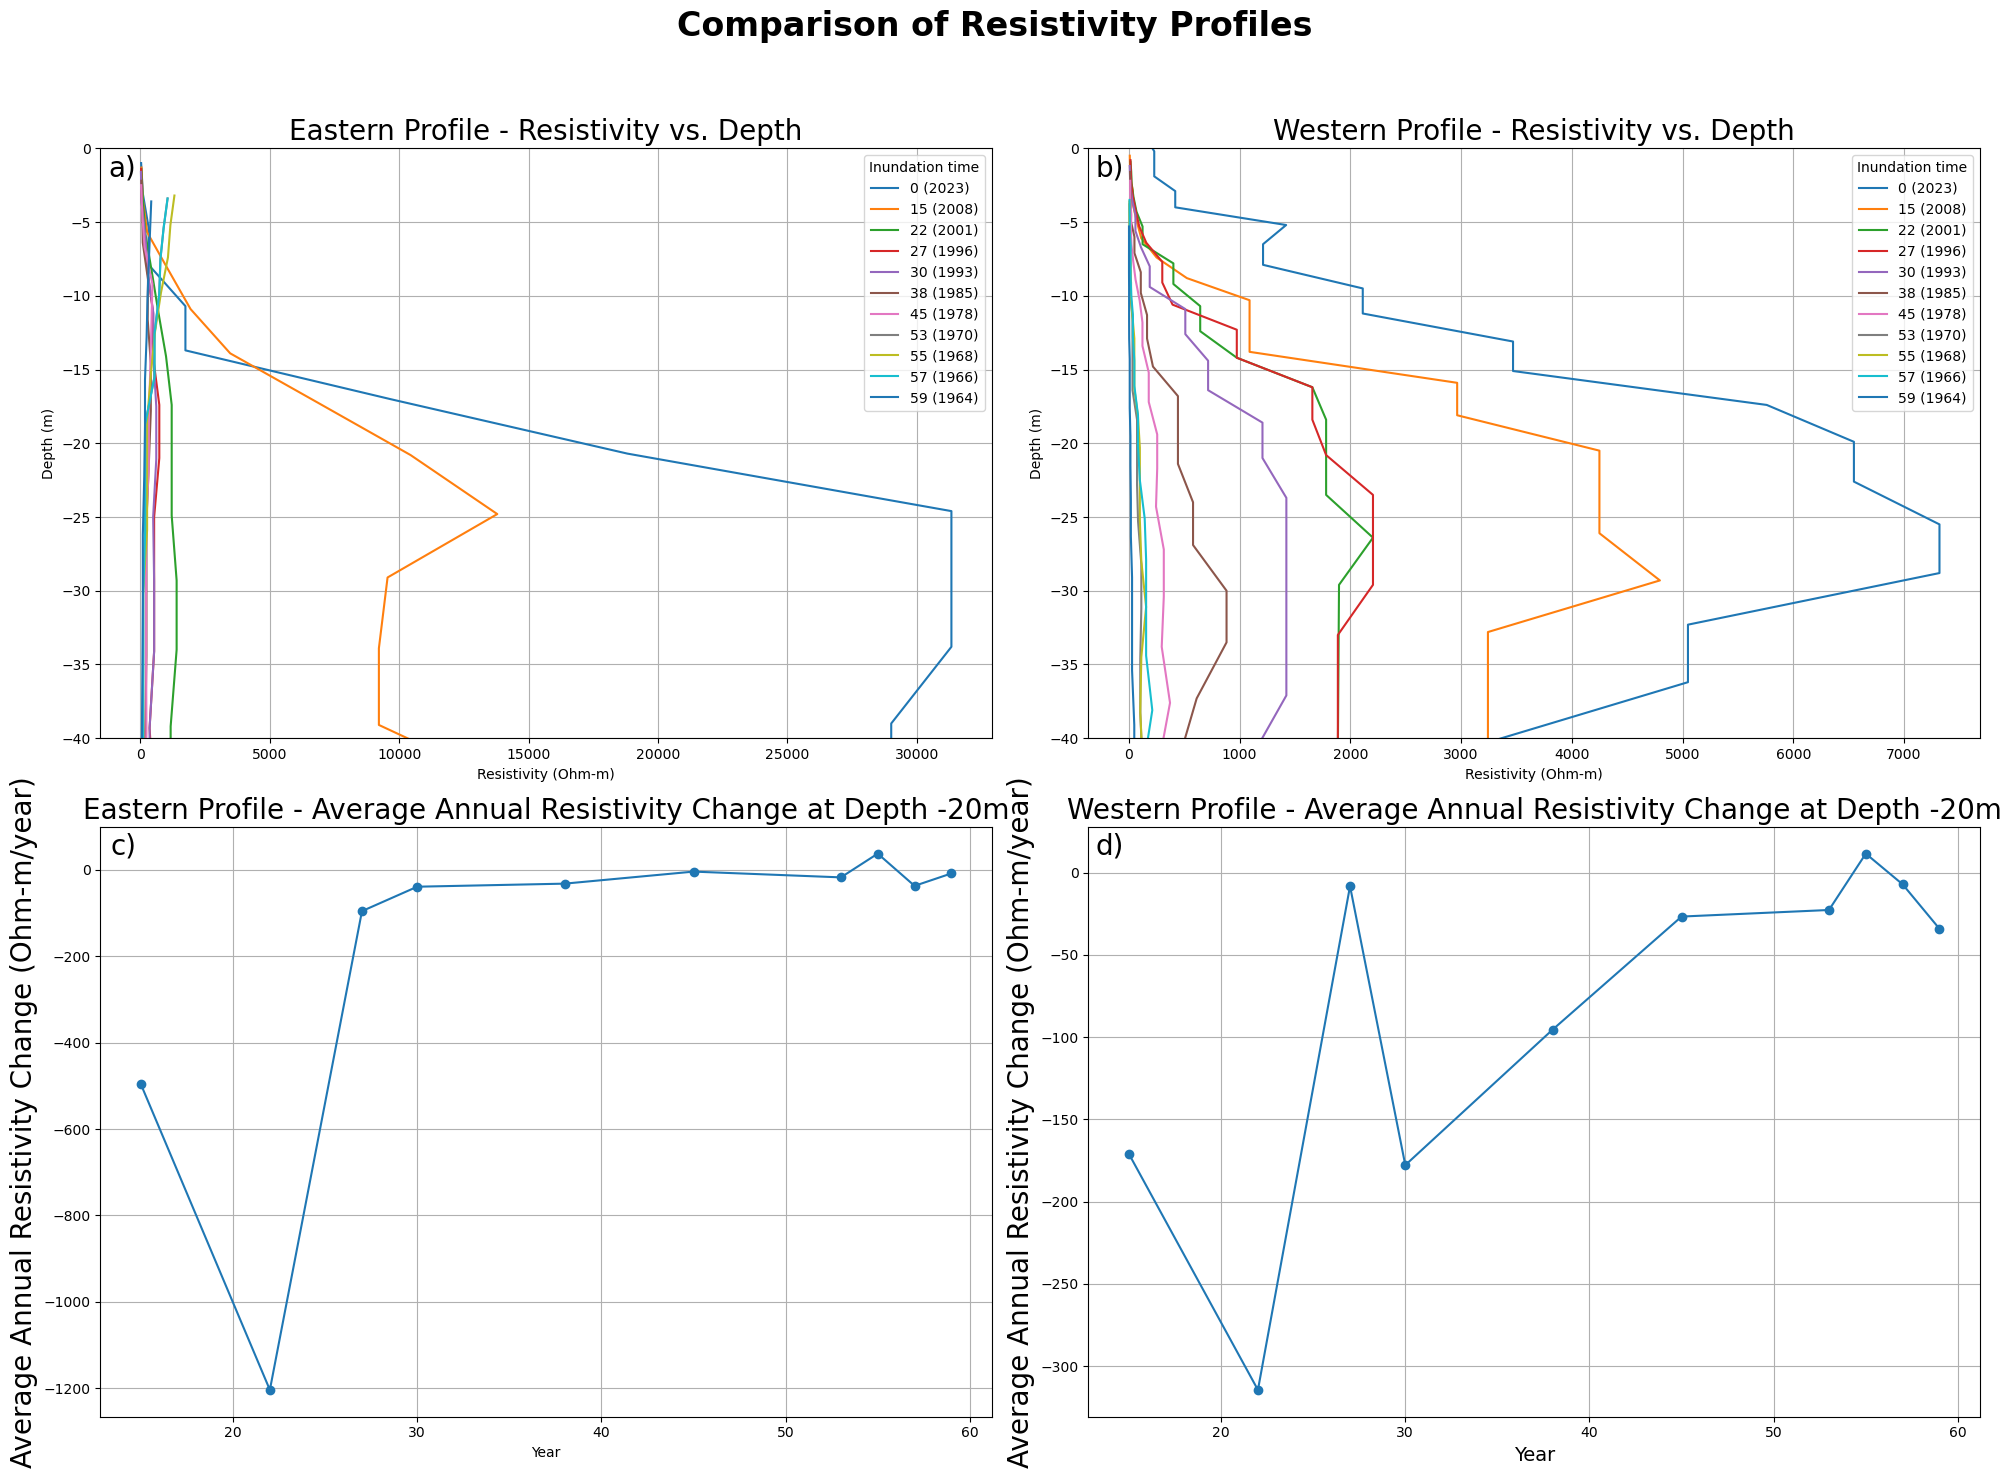

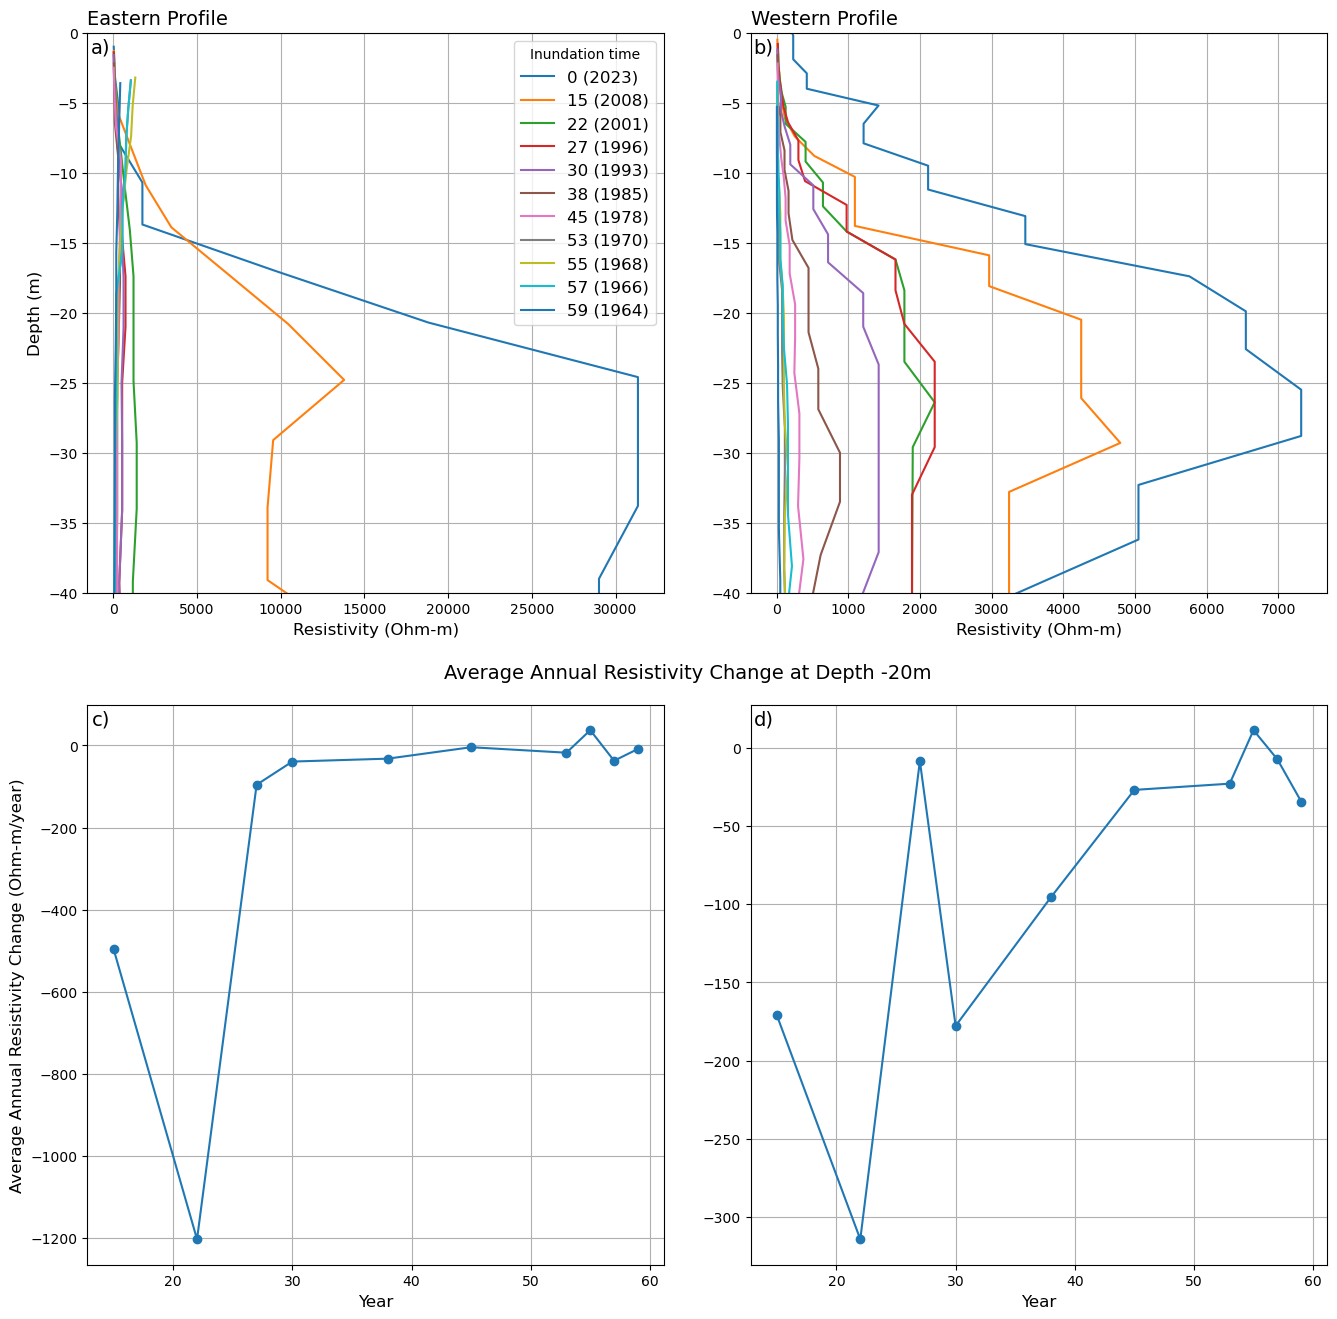

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Load data
east_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_eastern_and_south.csv")
west_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_western.csv")

east_shore = east_shore_df.to_numpy()
west_shore = west_shore_df.to_numpy()

# Unique years for both profiles
years_east = np.unique(east_shore[:, 4])
years_west = np.unique(west_shore[:, 4])

fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax0, ax1 = ax[0]
ax2, ax3 = ax[1]

# Eastern profile resistivity vs. depth
for year in years_east:
    data_year = east_shore[east_shore[:, 4] == year]
    ax0.plot(data_year[:, 2], data_year[:, 1], label=str(int(year)) + f' ({int(2023 - year)})')

ax0.set_ylabel('Depth (m)', fontsize=12)
ax0.set_ylim(-40, 0)
ax0.set_xlabel('Resistivity (Ohm-m)', fontsize=12)
ax0.legend(title='Inundation time', fontsize=12)
ax0.grid(True)

# Western profile resistivity vs. depth
for year in years_west:
    data_year = west_shore[west_shore[:, 4] == year]
    ax1.plot(data_year[:, 2], data_year[:, 1])

#ax1.set_ylabel('Depth (m)')
ax1.set_ylim(-40, 0)
ax1.set_xlabel('Resistivity (Ohm-m)', fontsize=12)
#ax1.legend(title='Inundation time')
ax1.grid(True)

# Eastern profile - Average annual resistivity change at depth -25m
results_east = []
for year in years_east:
    data_year = east_shore[east_shore[:, 4] == year]
    if len(data_year) > 0:
        data_year = data_year[np.argsort(data_year[:, 1])]
        depths = data_year[:, 1]
        resistivities = data_year[:, 2]
        interp_func = interp1d(depths, resistivities, kind='linear', fill_value='extrapolate')
        resistivity_at_20m = interp_func(-20)
        results_east.append({'Year': year, 'Resistivity_at_-20m': resistivity_at_20m})

results_df_east = pd.DataFrame(results_east)

change_list_east = []
for i in range(len(results_df_east) - 1):
    year1 = results_df_east.iloc[i]['Year']
    year2 = results_df_east.iloc[i + 1]['Year']
    resistivity1 = results_df_east.iloc[i]['Resistivity_at_-20m']
    resistivity2 = results_df_east.iloc[i + 1]['Resistivity_at_-20m']
    change = resistivity2 - resistivity1
    change_list_east.append(change / (year2 - year1))

change_df_east = pd.DataFrame({
    'Start_Year': results_df_east['Year'].iloc[:-1].values,
    'End_Year': results_df_east['Year'].iloc[1:].values,
    'Average_Annual_Change': change_list_east
})

ax2.plot(change_df_east['End_Year'], change_df_east['Average_Annual_Change'], marker='o', linestyle='-')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Average Annual Resistivity Change (Ohm-m/year)', fontsize=12)
ax2.grid(True)

# Western profile - Average annual resistivity change at depth -25m
results_west = []
for year in years_west:
    data_year = west_shore[west_shore[:, 4] == year]
    if len(data_year) > 0:
        data_year = data_year[np.argsort(data_year[:, 1])]
        depths = data_year[:, 1]
        resistivities = data_year[:, 2]
        interp_func = interp1d(depths, resistivities, kind='linear', fill_value='extrapolate')
        resistivity_at_20m = interp_func(-20)
        results_west.append({'Year': year, 'Resistivity_at_-20m': resistivity_at_20m})

results_df_west = pd.DataFrame(results_west)

change_list_west = []
for i in range(len(results_df_west) - 1):
    year1 = results_df_west.iloc[i]['Year']
    year2 = results_df_west.iloc[i + 1]['Year']
    resistivity1 = results_df_west.iloc[i]['Resistivity_at_-20m']
    resistivity2 = results_df_west.iloc[i + 1]['Resistivity_at_-20m']
    change = resistivity2 - resistivity1
    change_list_west.append(change / (year2 - year1))

change_df_west = pd.DataFrame({
    'Start_Year': results_df_west['Year'].iloc[:-1].values,
    'End_Year': results_df_west['Year'].iloc[1:].values,
    'Average_Annual_Change': change_list_west
})

ax3.plot(change_df_west['End_Year'], change_df_west['Average_Annual_Change'], marker='o', linestyle='-')
ax3.set_xlabel('Year', fontsize=12)
#ax3.set_ylabel('Average Annual Resistivity Change (Ohm-m/year)')
ax3.grid(True)

# Titles: Eastern and Western in the main title area, rest of the title centered
#fig.suptitle('Comparison of Resistivity Profiles', fontsize=24, fontweight='bold')

# Eastern and Western titles at the top of columns
ax0.set_title('Eastern Profile', fontsize=14, loc='left')
ax1.set_title('Western Profile', fontsize=14, loc='left')

# Common descriptive titles centered above relevant rows
#fig.text(0.5, 0.96, 'Resistivity vs. Depth', fontsize=14, ha='center', va='center')
fig.text(0.5, 0.48, 'Average Annual Resistivity Change at Depth -20m', fontsize=14, ha='center', va='center')

# Add "a", "b", "c", "d" labels to the panes
ax0.text(0.04, 0.99, 'a)', transform=ax0.transAxes, fontsize=14, va='top', ha='right')
ax1.text(0.04, 0.99, 'b)', transform=ax1.transAxes, fontsize=14, va='top', ha='right')
ax2.text(0.04, 0.99, 'c)', transform=ax2.transAxes, fontsize=14, va='top', ha='right')
ax3.text(0.04, 0.99, 'd)', transform=ax3.transAxes, fontsize=14, va='top', ha='right')

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.2, wspace=0.15)

#plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to accommodate the main title and descriptive titles
plt.show()


TypeError: Cannot index by location index with a non-integer key

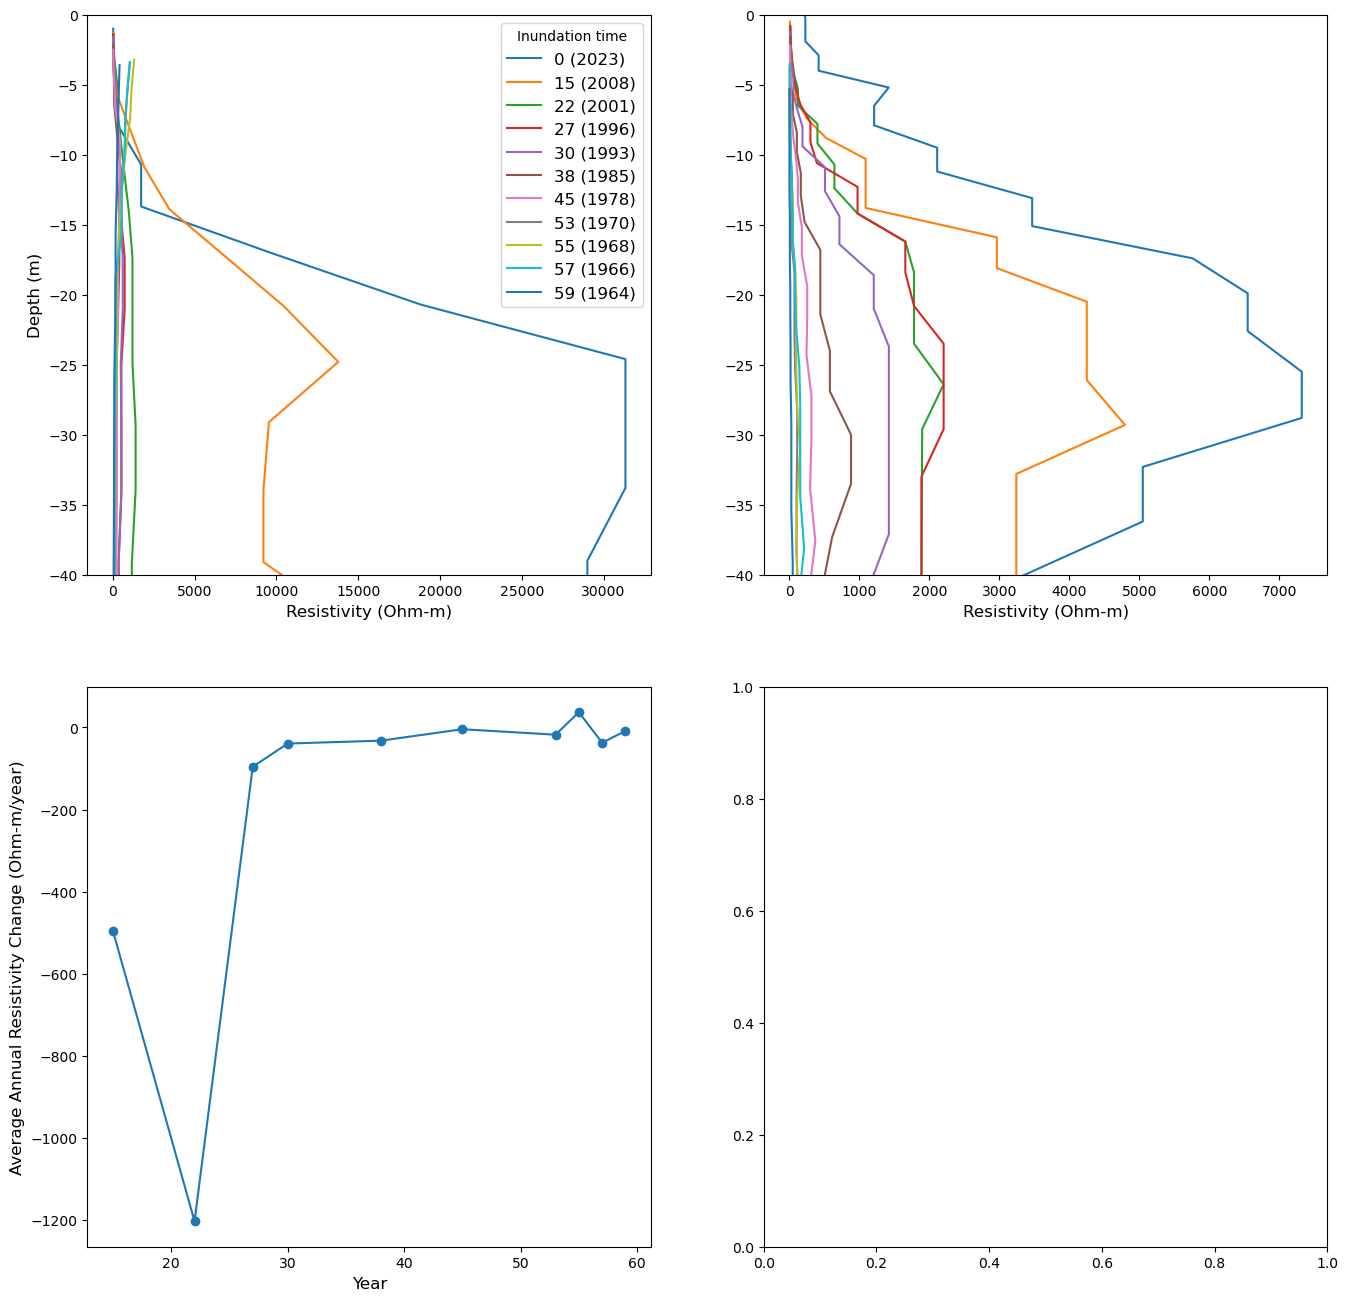